## Analyse de l'inflation sous-jacente
### Une comparaison analytique entre <br/>les méthodes statistiques classiques et les modèles de machine learning

<p>
Ce notebook présente la partie pratique de l'analyse et de la modélisation (ARIMA, VAR, RNA, XGBoost), élaboré dans le cadre de mon projet de fin d’études du Mastre en Statistique et Économétrie (MSE) – FSR/UM5.
</p>

#### Objectif :
Réaliser une étude analytique des modèles afin d’identifier celui qui modélise et prévoit mieux l’inflation sous-jacente.
#### La démarche :
Nous avons un échantillon de l'isj(Maroc) entre 2018-2024, nous avons déversifié la taille de dataset pour pouvoir tester plusieus situations. 
<dl>
    <dt>- T = 28 (échantillon réduit) fréquence : Trimistielle</dt>
    <dt>- T = 84 (échantillon étendu) fréquence : Mensuelle</dt>
    <dt>- Univariée k = 1 (la variable cible)</dt>
    <dt>- Multivariée simple k = 4 (la variable endogène + 3 variables exogènes causales)</dt>
    <dt>- Multivariée complexe(Des variables additionnelles pouvant avoir une interaction avec la variable cible) k = 7</dt>
    <dt>- La validation croisée : 80% d'entrainement 20% de test</dt>
    <dd> * Tester la capabilité d'apprendre sur les données vues (80%) et de généraliser sur des données non vues(20%)</dd>
    <dt>- La comparaison entre l'implémentaion manuelle de processus de modélisation et l'utilisation de blibliothèque</dt>
    <dd> * l'objective : valider la robustesse de l'implèmentation manuelle.</dd>
    <td>Un tableau contient tous les résultats, pour une analyse comparative et pour répondre aux questions :</td>
    <dd> * Laquelle de ces deux approches modèlise et prévoit mieux l'isj, ainsi quel est le modèle le plus performant ?</dd>
    <dd> * Est ce que les modèles d'apprentissage automatique peuvent surpasser les méthodes statistiques?</dd>
</dl>
 
#### Les données : Description des variables

| Variable                           | Unité de mesure      | Notation | Source | Périodicité       |
|------------------------------------|----------------------|----------|--------|-------------------|
| Taux de l’inflation sous-jacente   | %                    | tx_isj   | BAM    | Mensuelle (M)     |
| Masse monétaire                    | 10⁶ DH               | mm       | MEF    | Annuelle (A)      |
| Taux de croissance                 | %                    | tx_croi  | HCP    | Trimestrielle (T) |
| Taux directeur                     | %                    | tx_dire  | BAM    | Trimestrielle (T) |
| Taux de change                     | %                    | tx_chng  | BAM    | Trimestrielle (T) |
| Taux de chômage                    | %                    | tx_chmg  | HCP    | Trimestrielle (T) |
| Indice des valeurs à l’importation | indice (base 100)    | ivim     | HCP    | Trimestrielle (T) |
-----------------------------------------------------------------------------------------------------
<p style="fontfont-family: 'Arial', sans-serif; font-size: 16px;">** Les données disponibles sur les sites officiels de BAM, HCP et MEF<br/>
** Une particularité de la période étudiée réside dans la survenue de chocs exogènes : crise sanitaire, conflits géopolitiques, conditions météorologiques marquées par une sécheresse persistante, ainsi qu’un séisme dans la région d’El Haouz.</p>

- [1. ARIMA](#1-arima-)
  - [1.1 Implèmentation manuelle :](#11-implèmentation-manuelle-)
  - [1.2. Utilisatuin de la bibliothèque :](#arima-12)
  - [1.2. Analyse :](#arima-13)
- [2. VAR](#1-arima-)
  - [2.1 Implèmentation manuelle :](#11-implèmentation-manuelle-)
  - [2.2. Utilisatuin de la bibliothèque :](#arima-12)
  - [2.2. Analyse :](#arima-13)
- [3. RNA](#1-arima-)
  - [3.1 Implèmentation manuelle :](#11-implèmentation-manuelle-)
  - [3.2. Utilisatuin de la bibliothèque :](#arima-12)
  - [3.2. Analyse :](#arima-13)
- [4. XGBoost](#1-arima-)
  - [4.1 Implèmentation manuelle :](#11-implèmentation-manuelle-)
  - [4.2. Utilisatuin de la bibliothèque :](#arima-12)
  - [4.2. Analyse :](#arima-13)


##### Importation des librairies :

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.stattools import grangercausalitytests
from numpy.linalg import eigvals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate 

# Modèles statistiques et ML
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from tensorflow import keras
import tensorflow as tf
import random

# Évaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")

import sys

##### Chargement des données de Excel :

In [51]:
df = []
new_val_isj = []
futur_dates = []
model_overfitting = []
model_non_overfitting = []
def reload_data(freq) :
    file_path = "E:/noteBook/data.xlsx"
    if freq == "MS":
        df = pd.read_excel(file_path, sheet_name="Data_M", parse_dates=["M"])
        df.set_index("M", inplace=True)
    else :
        df = pd.read_excel(file_path, sheet_name="Data_T", parse_dates=["T"])
        df.set_index("T", inplace=True)

    df.index = pd.to_datetime(df.index)   # s’assurer que l’index est bien datetime 
    if freq == "MS" : df.index = pd.date_range(start="2018-01-01", periods=len(df), freq="MS") 
    else : 
        df.index = pd.date_range(start="2018-01-01", periods=len(df), freq="QS")
    
    # Valeurs réelles de l'isj de 2025 - BAM
    new_val_isj = [2.3, 2.2, 1.4, 1.0, 1.0, 1.0, 0.8, 0.6]
    # Générer les futures dates (2025)
    futur_dates = pd.date_range(start=df.index[-1] + 
                                 pd.offsets.MonthBegin(1), 
                                 periods=len(new_val_isj), freq="MS")
    
    return df, new_val_isj, futur_dates

##### Les fonctions nécissaires pour la modélisation : ARIMA, VAR, RNA, XGBoost.

In [3]:
def histogram(serie):
    plt.plot(serie)
    plt.title("Série chronologique-Inflation sous jacente(Maroc)")
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    plt.show()
    
"""
    Tester la stationnarité : retourne list staionnaire et nombre de stationnaire d
"""
list_stationnaires = pd.DataFrame(columns=['serie', 'd']) # à rinitialiser avant utiliser 'test_Stationnarite'
def test_Stationnarite(title, serie, d=0):
    result = adfuller(serie)
    if result[1] <= 0.05:
        list_stationnaires.loc[len(list_stationnaires)] = [title, d]
        return serie, d
    else:
        serie_diff = serie.diff().dropna() #Différenciation + suppression des vides
        return test_Stationnarite(title, serie_diff, d=d + 1)

"""
    Séparer la liste : retourne split_index, train, test
"""
def split_data(data) :
    n = len(data)
    split_index = int(n * 0.8)
    train = data.iloc[:split_index]
    test = data.iloc[split_index:]
    return split_index, train, test
"""
    calcule rho_k (ACF) pour k=0...nlags
    return x : 1D array-like
"""
def rho_k(x, nlags):
    x = np.asarray(x).astype(float)
    x = x[~np.isnan(x)]
    n = len(x)
    mu = x.mean()
    # biased estimator (divisé par n) — cohérent avec defs classiques
    gamma0 = np.sum((x - mu)**2) / n
    rho = np.empty(nlags + 1)
    rho[0] = 1.0
    for k in range(1, nlags + 1):
        gamma_k = np.sum((x[k:] - mu) * (x[:-k] - mu)) / n
        rho[k] = gamma_k / gamma0 if gamma0 != 0 else 0.0
    return rho

"""
    Retourne un tableau (DataFrame) avec rho_k (ACF),
    et indique si chaque lag est significatif.
"""
def acf_table(series, nlags=10, alpha=0.05):
    x = np.asarray(series).astype(float)
    x = x[~np.isnan(x)]
    N = len(x)

    # IC théorique
    z = norm.ppf(1 - alpha/2)
    ci = round(z / np.sqrt(N), 4)

    rho = rho_k(x, nlags)# ACF
    
    rows = []
    for k in range(1, nlags+1):
        rows.append({
            "Lag": k,
            "ACF (rho_k)": round(float(rho[k]), 4),
            "Signif ACF": "Oui" if abs(rho[k]) > ci else "Non",
            "IC" : f"[-{ci}, +{ci}]"
        })

    return pd.DataFrame(rows)

"""
    Levinson-Durbin recursion : calcul les phi_kk.
    Entrée r : array de lags autocorr r[0..nlags] (r[0]=1)
    Retourne:
      - phi_diag : array des phi_{k,k} pour k=1..nlags
      - phi_all  : tableau phi[k][j] (k=1..nlags, j=1..k) si besoin
      - sigma2   : prédiction erreur à chaque étape
"""
def levinson_durbin(r, nlags):
    phi = np.zeros((nlags+1, nlags+1))   # phi[k, j] : for order k, coefficient j (1-based)
    sigma2 = np.zeros(nlags+1)
    sigma2[0] = 1.0  
    # recursion
    for k in range(1, nlags+1):
        if k == 1:
            phi[k,1] = r[1]
            sigma2[k] = sigma2[k-1] * (1 - phi[k,1]**2)
        else:
            # compute reflection (kth) coefficient
            num = r[k] - sum(phi[k-1, j] * r[k-j] for j in range(1, k))
            den = sigma2[k-1]
            if den == 0:
                kk = 0.0
            else:
                kk = num / den
            # update phi
            for j in range(1, k):
                phi[k, j] = phi[k-1, j] - kk * phi[k-1, k-j]
            phi[k, k] = kk
            sigma2[k] = sigma2[k-1] * (1 - kk**2)
    # extract diagonal phi_{k,k}
    phi_diag = np.array([phi[k,k] for k in range(1, nlags+1)])
    return phi_diag, phi, sigma2

"""
    Retourne un tableau (DataFrame) avec rho_k (ACF), phi_kk (PACF diagonale),
    et indique si chaque lag est significatif.
"""
def acf_pacf_table(series, nlags=10, alpha=0.05):
    x = np.asarray(series).astype(float)
    x = x[~np.isnan(x)]
    N = len(x)

    # IC théorique
    z = norm.ppf(1 - alpha/2)
    ci = round(z / np.sqrt(N), 4)

    rho = rho_k(x, nlags)# ACF
    phi_diag, _, _ = levinson_durbin(rho, nlags)# PACF via Levinson-Durbin
    rows = []
    for k in range(1, nlags+1):
        rows.append({
            "Lag": k,
            "ACF (rho_k)": round(float(rho[k]), 4),
            "Signif ACF": "Oui" if abs(rho[k]) > ci else "Non",
            "PACF (phi_kk)": round(float(phi_diag[k-1]), 4),
            "Signif PACF": "Oui" if abs(phi_diag[k-1]) > ci else "Non",
            "IC" : f"[-{ci}, +{ci}]"
        })

    return pd.DataFrame(rows)

def acf_pacf_table(series, nlags=10, alpha=0.05):
    """
    Retourne un tableau (DataFrame) avec rho_k (ACF), phi_kk (PACF diagonale),
    et indique si chaque lag est significatif.
    """
    x = np.asarray(series).astype(float)
    x = x[~np.isnan(x)]
    N = len(x)

    # IC théorique
    z = norm.ppf(1 - alpha/2)
    ci = round(z / np.sqrt(N), 4)

    rho = rho_k(x, nlags)# ACF
    phi_diag, _, _ = levinson_durbin(rho, nlags)# PACF via Levinson-Durbin
    rows = []
    for k in range(1, nlags+1):
        rows.append({
            "Lag": k,
            "ACF (rho_k)": round(float(rho[k]), 4),
            "Signif ACF": "Oui" if abs(rho[k]) > ci else "Non",
            "PACF (phi_kk)": round(float(phi_diag[k-1]), 4),
            "Signif PACF": "Oui" if abs(phi_diag[k-1]) > ci else "Non",
            "IC" : f"[-{ci}, +{ci}]"
        })

    return pd.DataFrame(rows)

# Variables globales
B_est_opt, Y_est_opt, Sigma_u_opt, residus_opt = [], [], [], []
aic_min, sc_min, p_opt = 0, 0, 0
"""
    Régression MCO pour une série univariée (AR(p)).
    Retourne : B_est, Y_est, residus, Sigma_u, T, k, X, Y
"""
def mco_univariee(data, p):
    # data : pandas.Series ou ndarray 1D
    if hasattr(data, "values") : y = data.values
    else : y = np.asarray(data)
    T = y.shape[0]   # nombre d'observations
    k = 1            # une seule variable dépendante
    Y = y[p:].reshape(-1, 1)  # (T-p, 1)
    # Construction de la matrice des retards
    X_lags = np.column_stack([y[p - i - 1:T - i - 1] for i in range(p)])  # (T-p, p)
    # Ajouter la constante
    X = np.hstack([np.ones((X_lags.shape[0], 1)), X_lags])  # {(T-p, p+1)}
    B_est = np.linalg.pinv(X.T @ X) @ (X.T @ Y)  # Estimation des coefficients MCO {(p+1, 1)}
    Y_est = X @ B_est  # Valeurs prédites {(T-p, 1)}
    residus = Y - Y_est  # Résidus {(T-p, 1)}
    Sigma_u = ((residus.T @ residus) / (T - p)).item()  # Variance des résidus (Sigma_u) {scalaire}
    return B_est, Y_est, residus, Sigma_u, T, k, X, Y

"""
    Régression MCO pour une série multivariée (AR(p)).
    Retourne : B_est, Y_est, residus, Sigma_u, T, k, X, Y
"""
def mco_multivariee(data, p):
    T, k = data.shape  # T = obs, k = variables
    # Construction Y et X
    Y = data[p:]
    X = np.hstack([data[p - i - 1:T - i - 1] for i in range(p)])  # sans constante
    X = np.hstack([np.ones((X.shape[0], 1)), X])  # ajouter constante
    # Estimation MCO
    B_est = np.linalg.inv(X.T @ X) @ (X.T @ Y.values)
    Y_est = X @ B_est
    # Résidus (on recrée à chaque appel)
    residus = Y.values - Y_est
    Sigma_u = (residus.T @ residus) / (T - p)
    return B_est, Y_est, residus, Sigma_u, T, k, X, Y
"""
    Calcule AIC et SC pour un AR(p) à partir de la série 'data'.
"""
def ordre_p_optimal(data, p, type_data):
    _, _, _, Sigma_u, T, k, _, _ = mco_univariee(data, p) if type_data == "univariée" else mco_multivariee(data, p)
    log_det = np.log(Sigma_u) if type_data == "univariée" else np.log(np.linalg.det(Sigma_u))
    n_param = k * k * p  
    aic = log_det + (2 * n_param) / (T - p)
    sc = log_det + (n_param * np.log(T - p)) / (T - p)
    return aic, sc

def metriques(title, train_real, train_hat, test_real, test_hat):
    print(title)
    print(f"   Train : MSE={mean_squared_error(train_real, train_hat):.4f} | MAE={mean_absolute_error(train_real, train_hat):.4f} | R²={r2_score(train_real, train_hat):.4f}")
    print(f"   Test  : MSE={mean_squared_error(test_real, test_hat):.4f} | MAE={mean_absolute_error(test_real, test_hat):.4f} | R²={r2_score(test_real, test_hat):.4f}")

def residual_diagnostics(residus, nb_lags, alpha=0.05):
    if hasattr(residus, "values") : r = residus.values
    else : r = np.asarray(residus)

    print(f"Diagnostics des résidus de {nb_lags} lags:")
    print("Autocorrélation des résidus :\n\tH_0: pasd’autocorrélation des résidus;\n\tH_1:présence d’autocorrélation des résidus")
    print("Hétéroscédasticité :\n\tH_0: variance constante (homoscédasticité);\n\tH_1:variance non constante (hétéroscédasticité)")
    print("Normalité des résidus :\n\tH_0: résidus suivent une loi normale;\n\tH_1:résidus ne suivent pas une loi normale")
    for lag in range(1, nb_lags + 1) :
        # Ljung-Box
        lb_res = acorr_ljungbox(r, lags=[lag], return_df=True)
        lb_Q, lb_p = (lb_res['lb_stat'].iloc[0], lb_res['lb_pvalue'].iloc[0])
        
        # Ljung-Box sur carrés
        lb_sq = acorr_ljungbox(r**2, lags=[lag], return_df=True)
        lb_Q_sq, lb_p_sq = (lb_sq['lb_stat'].iloc[0], lb_sq['lb_pvalue'].iloc[0])
        
        # Test ARCH
        lm_stat, lm_pval, f_stat, f_pval = het_arch(r, nlags=lag)
        
        # Jarque-Bera
        jb_stat, jb_pval = stats.jarque_bera(r)
        
        out = pd.DataFrame([
        {"Test": f"Ljung-Box (error, lag={lag})",
        "Stat": round(lb_Q, 3), "p-value": round(lb_p, 3),
        "Décision": "Rejeter H0 (autocorr.)" if lb_p < alpha else "Ne pas rejeter H0"},

        {"Test": f"Ljung-Box (error^2, lag={lag})",
        "Stat": round(lb_Q_sq, 3), "p-value": round(lb_p_sq, 3),
        "Décision": "Rejeter H0 (effets ARCH)" if lb_p_sq < alpha else "Ne pas rejeter H0"},

        {"Test": f"ARCH (nlags={lag}) – LM",
        "Stat": round(lm_stat, 3), "p-value": round(lm_pval, 3),
        "Décision": "Rejeter H0 (hétéroscédasticité)" if lm_pval < alpha else "Ne pas rejeter H0"},

        {"Test": f"ARCH (nlags={lag}) – F",
        "Stat": round(f_stat, 3), "p-value": round(f_pval, 3),
        "Décision": "Rejeter H0 (hétéroscédasticité)" if f_pval < alpha else "Ne pas rejeter H0"},

        {"Test": "Jarque–Bera (normalité)",
        "Stat": round(jb_stat, 3), "p-value": round(jb_pval, 3),
        "Décision": "Rejeter H0 (non-normalité)" if jb_pval < alpha else "Ne pas rejeter H0"}
        ])
        #print(out)
        print(tabulate(out, headers='keys', tablefmt='pretty', showindex=False))

def visualisation(title, train, test, train_pred, test_pred, train_pred_bibl, test_pred_bibl, p, d, freq):
   # Supposons que tu as déjà défini train et test
    train_index = df['tx_isj'].index[p + d:len(train)]
    test_index  = df['tx_isj'].index[len(train):len(train)+len(test)]
    plt.figure(figsize=(12,6))
    plt.plot(df['tx_isj'], label="Réel - Train & Test", color="blue")
    # Créer des Series avec index de df
    if len(train_pred) > 0 :
        train_pred      = pd.Series(train_pred,      index=train_index)
        plt.plot(train_pred, label="Prévu Train", linestyle="--", color="green")
    if len(test_pred) > 0 :
        test_pred       = pd.Series(test_pred,       index=test_index)
        plt.plot(test_pred, label="Prévu Test", linestyle=":", color="green")
    if len(train_pred_bibl) > 0 :
        train_pred_bibl = pd.Series(train_pred_bibl, index=train_index)
        plt.plot(train_pred_bibl, label="Prévu Train Bibl", linestyle="--", color="red")
    if len(test_pred_bibl) > 0 :
        test_pred_bibl  = pd.Series(test_pred_bibl,  index=test_index)
        plt.plot(test_pred_bibl, label="Prévu Test Bibl", linestyle=":", color="red")
    plt.axvline(x=train_index[-1], color="orange", linestyle=":", label="Séparation Train/Test")
    plt.title(title)
    plt.xlabel(f"période[2018-2024]   ('{freq}', T= {84 if freq == 'MS' else 28})")
    plt.ylabel("tx_isj")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

C = [] # Cte
A = [] # Extraire les matrices Ai
np.set_printoptions(precision=4, suppress=True)
"""
    Calculer la matrice compagnon : return F
"""
def matrice_compagonon(B_est, p, k):
    global C, A
    C = []
    A = []
    # Extraire la constante
    C = B_est[0:1, :].T
    print("Cst : ", C.shape)

    for i in range(p):
        Ai = B_est[k*i + 1:k*(i+1) + 1, :].T
        A.append(Ai)
        print(f"A{i+1}  : ", Ai.shape)

    # Construire matrice compagnon
    top = np.hstack(A)
    bottom = np.eye(k*(p-1), k*p)
    return np.vstack([top, bottom])

"""
    Verifier la stabilité le système :
"""
def stability_system(F, p) :
    # Valeurs propres
    eigenvalues = eigvals(F)
    print("Valeurs propres:\n", eigenvalues)
    if np.all(np.abs(eigenvalues) < 1) : 
        print(f"=> Le modèle VAR({p}) est stable.")
        return True
    else : 
        print(f"=> Le modèle VAR({p}) n'est pas stable")
        return False

target = 'tx_isj'
summary = []
non_causales = []
var_causales = []
"""
    Tester la causalité : Teste la causalité de Granger de chaque variable vers la variable cible.
    Affiche la p-valeur du test de Fisher.
"""
def test_causalite(data, p) :
    print(f"\nTest de causalité de Granger : les variables causales et les lags qui correpondent p = {p}")
    summary.clear()
    non_causales.clear()
    var_causales.clear()
    for var in data.columns.drop(target):
        causale = False
        resultat = grangercausalitytests(df[[target, var]], maxlag=p, verbose=False)
        for lag in range(1, p + 1):
            p_value = resultat[lag][0]['ssr_ftest'][1]
            if p_value < 0.05 : 
                var_causales.append({"variable": var, "lag": lag, "p_value": round(p_value,3)})
                causale = True  # au moins une causalité trouvée
        
        if causale == False and var != target :
            non_causales.append(var)
    print(pd.DataFrame(var_causales))

#### 🔹1. ARIMA :

##### 1.1. Implèmentation manuelle (model 1 et 3):

In [70]:
# Initialisation :
freq = "MS" # à changer {"MS"|"QS"}  échantillon: {étendu|reduit} Freq: {Mensuelle|Trimestrielle}
df, new_val_isj, futur_dates = reload_data(freq) 
target = 'tx_isj'
serie = df["tx_isj"].dropna()

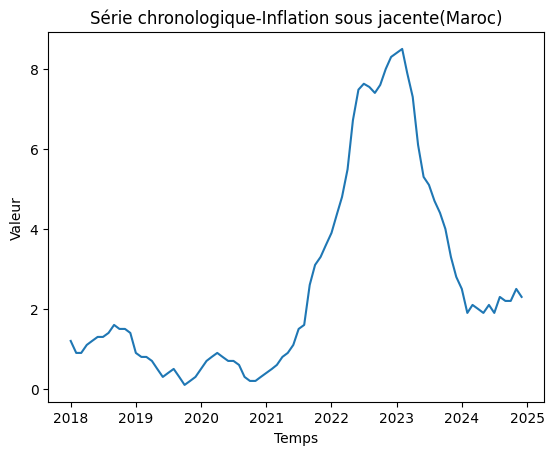

1. par la présenation graphique : la présence d'une tendance indique la non-stationnarité
2. ségmnentons l'éch en 2 sous-éch : une série est stationnaire si : la E(Xi), la V(Xi) , cov(Xt, Xt+s) 
ne dépends pas de t mais de lag s 'la covariance entre Xt et Xt+s doit être la même quel 
que soit t' doivent être toutes constante
Segment 1 : Moyenne = 0.764  | Variance = 0.166
Segment 2 : Moyenne = 4.492  | Variance = 5.462

Autocovariances :
Lag 1 : Segment 1 = 0.1623 | Segment 2 = 5.2593
Lag 2 : Segment 1 = 0.1654 | Segment 2 = 5.0826
Lag 3 : Segment 1 = 0.1692 | Segment 2 = 4.9865
ni la moyenne, ni la varaiance, ni les cov sont constantes : pas de stationnarité au sens large
3. ACF :  une série stationnaire, l'acf tend vers 0 rapidement, la décroissance lentement indique une autocorrélation elevée diminue lentement, qui signe classique de non-stationnarité / présence d'une racine unitaire 
 Lag  ACF (rho_k) Signif ACF                 IC
   1       0.9876        Oui [-0.2138, +0.2138]
   

In [53]:
# 1 - Stationnarité :
if len(serie) == 0 :
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
histogram(serie)
print("1. par la présenation graphique : la présence d'une tendance indique la non-stationnarité")
y1 = serie[:len(serie)//2]
y2 = serie[len(serie)//2:]

print("2. ségmnentons l'éch en 2 sous-éch : une série est stationnaire si : "\
    "la E(Xi), la V(Xi) , cov(Xt, Xt+s) \n" \
"ne dépends pas de t mais de lag s 'la covariance entre Xt et Xt+s doit être la même quel \n" \
"que soit t' doivent être toutes constante")
print("Segment 1 : Moyenne =", round(np.mean(y1), 3), " | Variance =", round(np.var(y1), 3))
print("Segment 2 : Moyenne =", round(np.mean(y2), 3), " | Variance =", round(np.var(y2), 3))
def autocovariance(series, lag):
    n = len(series)
    mean = np.mean(series)
    return np.sum((series[:n - lag] - mean) * (series[lag:] - mean)) / (n - lag)
lags = [1, 2, 3]
print("\nAutocovariances :")
for k in lags:
    cov1 = autocovariance(y1, k)
    cov2 = autocovariance(y2, k)
    print(f"Lag {k} : Segment 1 = {cov1:.4f} | Segment 2 = {cov2:.4f}")
print("ni la moyenne, ni la varaiance, ni les cov sont constantes : pas de stationnarité au sens large")

print("3. ACF :  une série stationnaire, l'acf tend vers 0 rapidement, la décroissance lentement indique" \
" une autocorrélation elevée diminue lentement, qui signe classique de non-stationnarité / " \
"présence d'une racine unitaire ")
print(acf_table(serie, nlags=20).to_string(index=False))

list_stationnaires = pd.DataFrame(columns=['serie', 'd'])# doit être reinitilaiser avant 'test_Stationnarite'
serie_stationnaire, d = test_Stationnarite("tx_isj", serie)
print("4. Le test de racine unitaire : Test de Ducky Foller ")
print(f"=> La série est sationnarisée aprés {d} différentiation(s) (d = {d})")

In [54]:
# 2 - Découpage :
if len(serie_stationnaire) == 0 :
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
split_index, train_arima, test_arima = split_data(serie_stationnaire)
print(f"=> Le découpage : Train {train_arima.shape} et Test {test_arima.shape}")

=> Le découpage : Train (66,) et Test (17,)


In [55]:
# 3 - L'autocorrélation (ACF) et l'autocorrélation partialle (PACF)
if len(serie_stationnaire) == 0 :
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
print(acf_pacf_table(serie_stationnaire, nlags=10).to_string(index=False))
print("=> Les ordres signifcatifs : p = {1, 4}         |  d = 1  |  q = 2 pour T=28")
print("=> Les ordres signifcatifs : p = {1, 5, 9, 10}  |  d = 1  |  q = 8 pour T=84")

 Lag  ACF (rho_k) Signif ACF  PACF (phi_kk) Signif PACF                 IC
   1       0.6587        Oui         0.6587         Oui [-0.2151, +0.2151]
   2       0.5123        Oui         0.1385         Non [-0.2151, +0.2151]
   3       0.4082        Oui         0.0472         Non [-0.2151, +0.2151]
   4       0.2467        Oui        -0.1274         Non [-0.2151, +0.2151]
   5       0.3446        Oui         0.3238         Oui [-0.2151, +0.2151]
   6       0.2860        Oui        -0.0634         Non [-0.2151, +0.2151]
   7       0.3056        Oui         0.1293         Non [-0.2151, +0.2151]
   8       0.3614        Oui         0.0862         Non [-0.2151, +0.2151]
   9       0.1623        Non        -0.2543         Oui [-0.2151, +0.2151]
  10      -0.0193        Non        -0.3536         Oui [-0.2151, +0.2151]
=> Les ordres signifcatifs : p = {1, 4}         |  d = 1  |  q = 2 pour T=28
=> Les ordres signifcatifs : p = {1, 5, 9, 10}  |  d = 1  |  q = 8 pour T=84


In [56]:
# 4 - les ordres optimal : par MCO (MCO plus simple mais ne prend pas en consédèration MA(q), 
# MLE, oui ce qui le rends plus performant pour estimé aic)
if len(serie_stationnaire) == 0 :
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
max_p = 10
result_aic = []
for p in range(1, max_p + 1):
    aic, sc = ordre_p_optimal(serie_stationnaire, p, "univariée")
    if p == 1 :
        aic_min = aic 
        sc_min = sc
        p_opt = p
    elif aic < aic_min : 
        aic_min = aic 
        sc_min = sc
        p_opt = p
    result_aic.append({"AIC" : round(aic, 3), "SC" : round(sc, 3), "p" : p})
print(pd.DataFrame(result_aic))
print(f"=> L'ordre optimal p: {p_opt} nous pouvons tester par la suite :")
print(pd.DataFrame(result_aic).nsmallest(3, 'AIC')[1:])

     AIC     SC   p
0 -2.583 -2.554   1
1 -2.568 -2.509   2
2 -2.541 -2.452   3
3 -2.520 -2.400   4
4 -2.604 -2.453   5
5 -2.571 -2.388   6
6 -2.550 -2.335   7
7 -2.519 -2.272   8
8 -2.577 -2.297   9
9 -2.653 -2.340  10
=> L'ordre optimal p: 10 nous pouvons tester par la suite :
     AIC     SC  p
4 -2.604 -2.453  5
0 -2.583 -2.554  1


In [57]:
# 5 - Estimation des coeficients AR(p) de ARIMA(p, d , q)
if len(train_arima) == 0 or p_opt == 0:
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
p = p_opt
q = 8 if freq == "MS" else 2 

B_est, Y_est, residus, Sigma_u, T, k, X, y = mco_univariee(train_arima, p)
# Matrice var-covar
var_B = Sigma_u * np.linalg.inv(X.T @ X)
se_B = np.sqrt(np.diag(var_B))
# t-stats et p-values
t_stats = B_est.flatten() / se_B
p_values = [2 * (1 - stats.t.cdf(np.abs(t), df=T - k)) for t in t_stats]
print(pd.DataFrame({
        'Coefficient': B_est.flatten(),
        'Std. Error': se_B,
        't-Statistic': t_stats,
        'p-Value': p_values}))

    Coefficient  Std. Error  t-Statistic       p-Value
0      0.010426    0.036352     0.286817  7.751650e-01
1      0.708368    0.128834     5.498320  6.907065e-07
2      0.058846    0.159342     0.369306  7.131000e-01
3     -0.010681    0.163021    -0.065518  9.479631e-01
4     -0.136428    0.165324    -0.825216  4.122673e-01
5      0.270626    0.172755     1.566537  1.220788e-01
6     -0.122366    0.174816    -0.699968  4.864448e-01
7      0.074042    0.176738     0.418935  6.766447e-01
8      0.354110    0.177222     1.998113  4.989155e-02
9     -0.134519    0.183013    -0.735026  4.649674e-01
10    -0.353310    0.154939    -2.280319  2.587656e-02


In [58]:
# 6 - Prédiction :
if len(Y_est) == 0 or p == 0:
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")

for lag in range(1, p + 1):  
    df[f"tx_isj_t-{lag}"] = df["tx_isj"].shift(lag)
df_clean = df.dropna()# Nettoyage
X_columns = [f"tx_isj_t-{lag}" for lag in range(1, p + 1)]
X = df_clean[X_columns].values[d:] # les features 

y_real_all = df_clean['tx_isj'].values[d:].reshape(-1, 1) # le label
y_pred_all = (B_est[:1] + X @ B_est[1:]).ravel() # avec C   {(T, k+1) * (k+1, k+1)}
#y_pred_all = X @ B_est # sans C    {(T, k) * (k, k)}

y_train_real = y_real_all[:split_index-p]
y_test_real  = y_real_all[split_index-p:]
y_train_pred = y_pred_all[:split_index-p]
y_test_pred  = y_pred_all[split_index-p:]

In [59]:
# 7 - Calcul des métriques
metriques(f"=> Performance de l'implèmentation manuelle de ARIMA({p}, {d}, {q}) T = {84 if freq=="MS" else 28} :", 
          y_train_real, y_train_pred, 
          y_test_real, y_test_pred)

=> Performance de l'implèmentation manuelle de ARIMA(10, 1, 8) T = 84 :
   Train : MSE=1.0036 | MAE=0.7593 | R²=0.8854
   Test  : MSE=1.1968 | MAE=1.0738 | R²=-0.5720


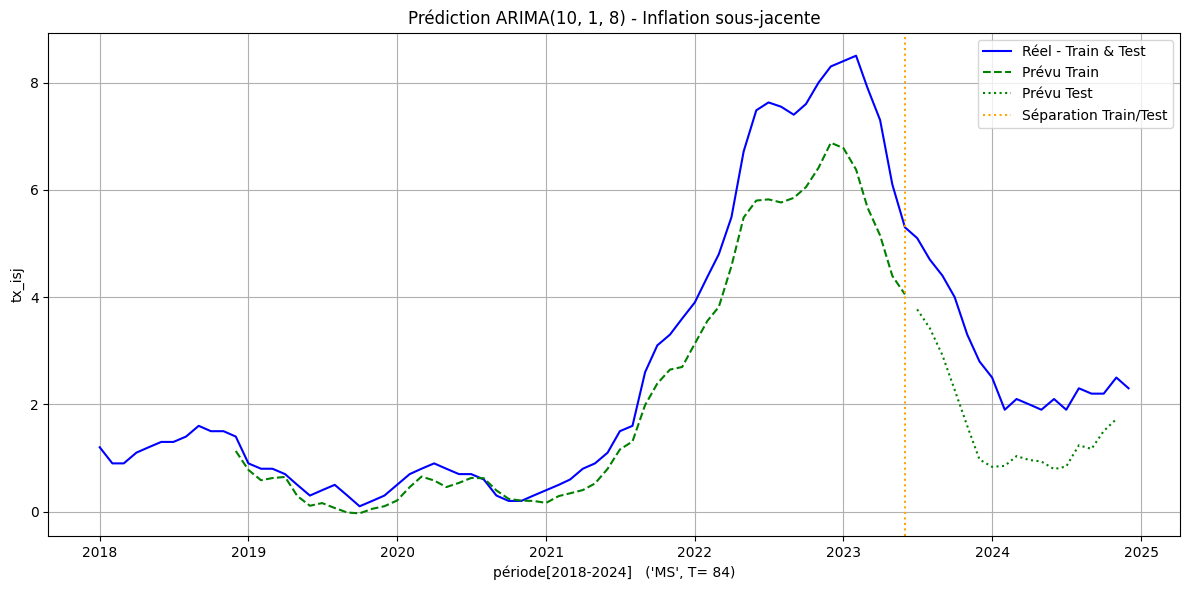

In [60]:
# 8 - Visualisation
if len(train_arima) == 0 or p == 0:
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
visualisation(f"Prédiction ARIMA({p}, {d}, {q}) - Inflation sous-jacente", 
              train_arima, test_arima,
              y_train_pred[d:], y_test_pred, 
              [], [], 
              p, d, freq)

##### 1.2. Utilisation de la bibliothèque ARIMA (model 2 et 4):

=> Performance de la Bibliothèque ARIMA(10, 1, 8) T = 84 :
   Train : MSE=0.0554 | MAE=0.1550 | R²=0.9928
   Test  : MSE=2.0529 | MAE=1.3452 | R²=-1.6966


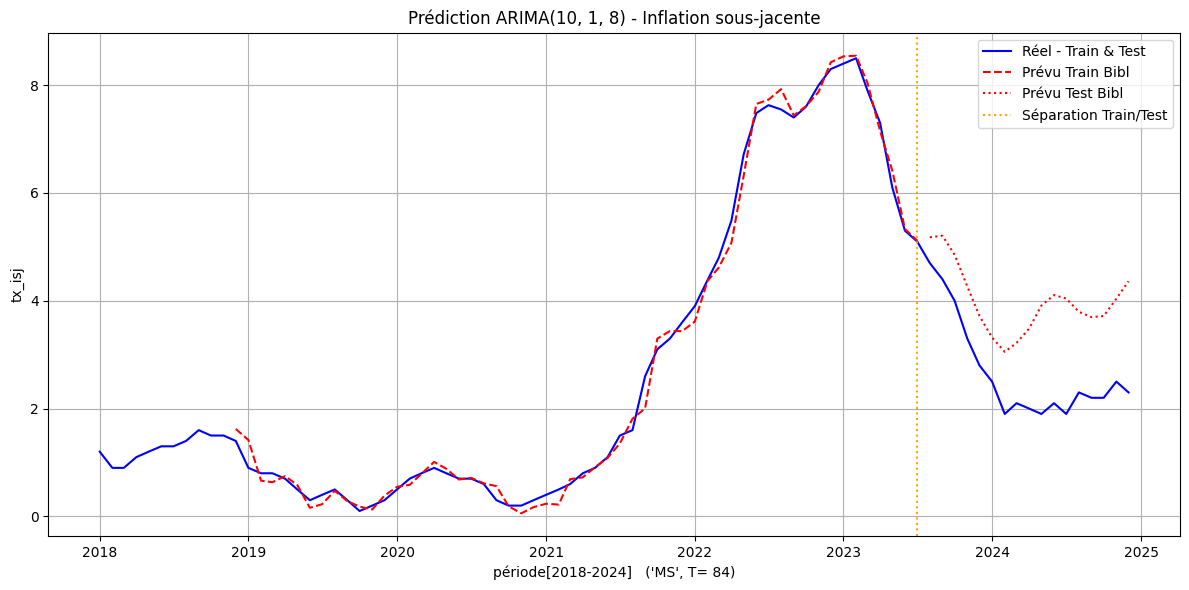

In [61]:
if len(serie) == 0 or p == 0 or d == 0 or q == 0:
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
split_index, train_arima, test_arima = split_data(serie) # non stationnaire
model = ARIMA(train_arima, order=(p, d, q), freq=freq)
results_model = model.fit()
residuals_bibl = results_model.resid
# Prédiction train et test : Statsmodels ARIMA gère déjà la réintégration avec typ='levels'
train_pred_bibl = results_model.predict(start=train_arima.index[0], 
                                        end=train_arima.index[-1], typ='levels')
test_pred_bibl = results_model.predict(start=test_arima.index[0], 
                                       end=test_arima.index[-1], typ='levels')

metriques(f"=> Performance de la Bibliothèque ARIMA({p}, {d}, {q}) T = {84 if freq=="MS" else 28} :", 
          train_arima, train_pred_bibl, 
          test_arima, test_pred_bibl)

visualisation(f"Prédiction ARIMA({p}, {d}, {q}) - Inflation sous-jacente", 
              train_arima, test_arima,
              [], [], 
              train_pred_bibl, test_pred_bibl, p, d, freq)

=> Performance de l'implèmentation manuelle de ARIMA(10, 1, 8) T = 84 :
   Train : MSE=1.0036 | MAE=0.7593 | R²=0.8854
   Test  : MSE=1.1968 | MAE=1.0738 | R²=-0.5720
=> Performance de la Bibliothèque ARIMA(10, 1, 8) T = 84 :
   Train : MSE=0.0554 | MAE=0.1550 | R²=0.9928
   Test  : MSE=2.0529 | MAE=1.3452 | R²=-1.6966


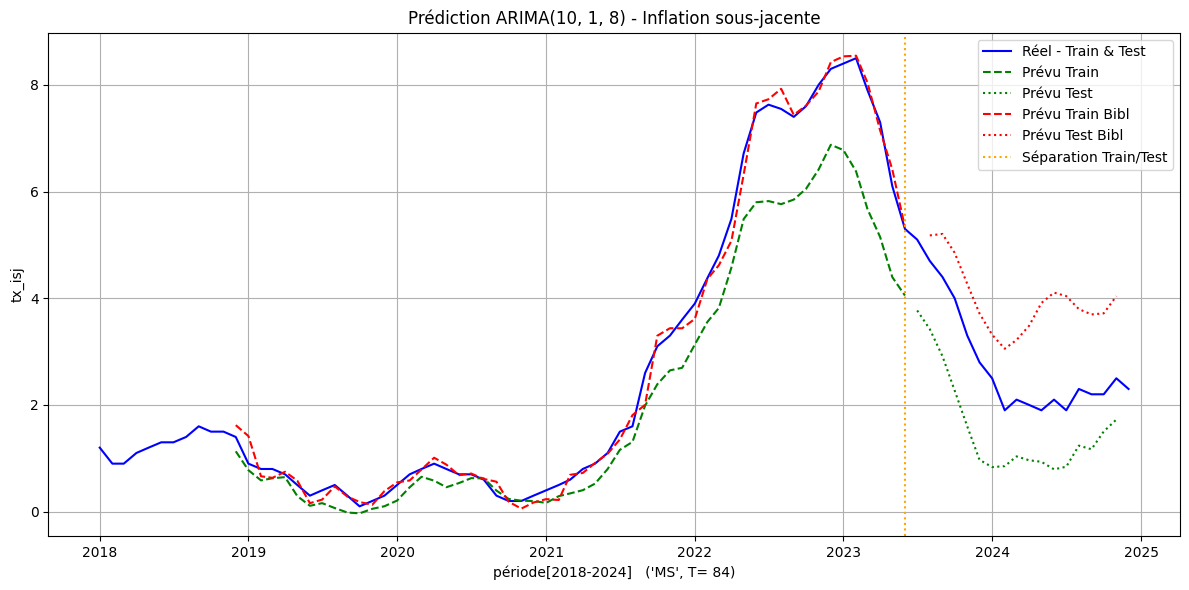

In [62]:
# 9 - Comparaison entre l’implémentation manuelle et l’utilisation de la bibliothèque dédiée
if len(train_arima) == 0 or p == 0 or d == 0 or q == 0:
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")

metriques(f"=> Performance de l'implèmentation manuelle de ARIMA({p}, {d}, {q}) T = {84 if freq=="MS" else 28} :", 
          y_train_real, y_train_pred, 
          y_test_real, y_test_pred)

metriques(f"=> Performance de la Bibliothèque ARIMA({p}, {d}, {q}) T = {84 if freq=="MS" else 28} :", 
          train_arima, train_pred_bibl, 
          test_arima, test_pred_bibl)

visualisation(f"Prédiction ARIMA({p}, {d}, {q}) - Inflation sous-jacente", 
              train_arima[d:], test_arima,
              y_train_pred[d:], y_test_pred,
              train_pred_bibl, test_pred_bibl, 
              p, d, freq)

In [63]:
# 10. Tester la capacité de modèle 'MS': sur t+k, k>=1 'univariées' ou k=1 'multivariées'
if freq == "MS" : 
    print("La capacité de modèle de prévoir des valeurs futur hors dataset :")
    forecast_obj = results_model.get_forecast(steps=len(new_val_isj))

    # valeurs prédites et IC
    pred_mean = forecast_obj.predicted_mean
    conf_int  = forecast_obj.conf_int()

    # Construire un DataFrame propre
    new_isj_pred = pd.DataFrame({
        "isj 2025" : new_val_isj,
        "Prévision": pred_mean.values,
        "IC_inf": conf_int.iloc[:, 0].values,
        "IC_sup": conf_int.iloc[:, 1].values,
    }, index=futur_dates)

    print(new_isj_pred)

La capacité de modèle de prévoir des valeurs futur hors dataset :
            isj 2025  Prévision    IC_inf    IC_sup
2025-01-01       2.3   5.178103  4.843704  5.512501
2025-02-01       2.2   5.205915  4.552799  5.859031
2025-03-01       1.4   4.852602  3.891132  5.814072
2025-04-01       1.0   4.269041  3.016413  5.521669
2025-05-01       1.0   3.716818  2.174721  5.258915
2025-06-01       1.0   3.317365  1.412689  5.222042
2025-07-01       0.8   3.053495  0.803757  5.303232
2025-08-01       0.6   3.218637  0.608205  5.829070


<p style="font-size:20px">Rappel : Pour valider le modèle, il est nécessaire d’effectuer certains tests visant à détecter d’éventuelles violations des hypothèses sur les erreurs :</p>
<p style="font-size:18px">Le test <b>Ljung-Box (résidus, lag)</b> permet : de détecter la corrélation entre erreurs à un instant (lag), de vérifier si le modèle a correctement capturé la dynamique de la série, car des résidus autocorrélés indiquent un modèle mal ajusté.<p/>
<p style="font-size:18px">Le test <b>Ljung-Box (résidus², lag)</b> : teste l’autocorrélation dans la variance des résidus pour détecter des effets <b>d’hétéroscédasticité conditionnelle</b> (type ARCH), c’est-à-dire si la volatilité des erreurs dépend de leurs valeurs passées.<p/>
<p style="font-size:18px">Test <b>ARCH - LM</b> : test de Lagrange Multiplier qui évalue la présence d’un effet ARCH en regardant si les résidus au carré sont autocorrélés. La statistique suit une loi du chi-deux, adaptée aux échantillons larges.<p/>
<p style="font-size:18px">Test <b>ARCH - F</b> : basée sur une statistique F, plus appropriée pour les petits échantillons, teste également la dépendance de la variance des résidus dans le temps.<p/>
<p style="font-size:18px">Test <b>Jarque Bera</b> : teste la notmalité de distribution de résidus.<p/>

In [16]:
# 10 - Validation de modèle : tester les violation des hypothèses des erreurs
residual_diagnostics(residus, 5, alpha=0.05)
print("=> pas d'autocorrélation (les erreurs sont indépendantes), " \
"pas d'hétéroscédasticité (leur variance est constane dans le temps) : \n\t Les résidus sont du bruit blanc au sens strict" \
"\n\t Le modèle a correctement capturé la dynamique de la série (aucune autocorrélation, pas d’effet ARCH)." \
"\n\t L'anormalité des erreurs : Cela peut venir de queues lourdes, ou de distributions asymétriques")

Diagnostics des résidus de 5 lags:
Autocorrélation des résidus :
	H_0: pasd’autocorrélation des résidus;
	H_1:présence d’autocorrélation des résidus
Hétéroscédasticité :
	H_0: variance constante (homoscédasticité);
	H_1:variance non constante (hétéroscédasticité)
Normalité des résidus :
	H_0: résidus suivent une loi normale;
	H_1:résidus ne suivent pas une loi normale
+----------------------------+--------+---------+----------------------------+
|            Test            |  Stat  | p-value |          Décision          |
+----------------------------+--------+---------+----------------------------+
|  Ljung-Box (error, lag=1)  | 0.122  |  0.727  |     Ne pas rejeter H0      |
| Ljung-Box (error^2, lag=1) | 0.015  |  0.904  |     Ne pas rejeter H0      |
|    ARCH (nlags=1) – LM     | 0.014  |  0.907  |     Ne pas rejeter H0      |
|     ARCH (nlags=1) – F     | 0.013  |  0.909  |     Ne pas rejeter H0      |
|  Jarque–Bera (normalité)   | 14.938 |  0.001  | Rejeter H0 (non-normalité)

##### 1.3. Analyse :

<pre>
=> Performance de l'implèmentation manuelle de ARIMA(4, 1, 2) T = 28 :
   Train : MSE=3.5926 | MAE=1.5284 | R²=0.6050
   Test  : MSE=16.9274 | MAE=4.0564 | R²=-16.6282
=> Performance de la Bibliothèque ARIMA(4, 1, 2) T = 28 :
   Train : MSE=0.2520 | MAE=0.3905 | R²=0.9669
   Test  : MSE=1.5659 | MAE=1.0561 | R²=-0.6308

=> Performance de l'implèmentation manuelle de ARIMA(10, 1, 8) T = 84 :
   Train : MSE=1.0036 | MAE=0.7593 | R²=0.8854
   Test  : MSE=1.1968 | MAE=1.0738 | R²=-0.5720
=> Performance de la Bibliothèque ARIMA(10, 1, 8) T = 84 :
   Train : MSE=0.0554 | MAE=0.1550 | R²=0.9928
   Test  : MSE=2.0529 | MAE=1.3452 | R²=-1.6966
</pre>
Le modèle ARIMA a bien appris sur les données d’entraînement, mais n’a pas réussi à généraliser sur les données non vues. Cela met en évidence sa limite pour modéliser l’inflation sous-jacente, un indicateur macroéconomique qu’il est très rare de pouvoir l'expliquer de manière totalement indépendante des autres variables. En raison de sa structure univariée, ARIMA n’a pas pu capturer la dynamique complexe de ce phénomène. Pour dépasser cette limite, il est donc nécessaire de tester d’autres modèles capables de détecter et d’exploiter les interactions dynamiques entre plusieurs variables.

#### 🔹2. VAR :

##### 2.1 Implèmentation manuelle (model 5 et 7):

In [71]:
freq = "MS" # à changer {"MS"|"QS"}  échantillon: {étendu|reduit} Freq: {Mensuelle|Trimestrielle}
df, new_val_isj, futur_dates = reload_data(freq) 
target = 'tx_isj'

In [65]:
# 1 - Stationnarité :
vectors = []
list_stationnaires = pd.DataFrame(columns=['serie', 'd'])
for var in df.columns :
    vectors.append(test_Stationnarite(var, df[var], 0))  
df_stationnaire = pd.concat([v[0] for v in vectors], axis=1).dropna()
d = max(list_stationnaires['d']) # get d
print(f"{list_stationnaires}")
print(f"=> Les séries sont sationnarisées aprés {d} différentiation(s) (d = {d})")

     serie  d
0   tx_isj  1
1  tx_croi  0
2  tx_dire  1
3       mm  1
4  tx_chmg  1
5  tx_chng  0
6     ivim  1
=> Les séries sont sationnarisées aprés 1 différentiation(s) (d = 1)


In [66]:
# 2 - découpage train/test
split_index, train_var, test_var = split_data(df_stationnaire)
print(f"=> Le découpage : Train {train_var.shape} et Test {test_var.shape}")

=> Le découpage : Train (66, 7) et Test (17, 7)


In [67]:
# 3 . chercher l'ordre optimal
if len(train_var) == 0 :
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
max_p = 5
result_aic = []
for p in range(1, max_p + 1):
    aic, sc = ordre_p_optimal(train_var, p, "multivariée")
    if p == 1 :
        aic_min = aic 
        sc_min = sc
        p_opt = p
    elif aic < aic_min : 
        aic_min = aic 
        sc_min = sc
        p_opt = p
    result_aic.append({"AIC" : round(aic, 3), "SC" : round(sc, 3), "p" : p})
print(pd.DataFrame(result_aic))
print(f"=> L'ordre optimal p: {p_opt}")

      AIC      SC  p
0 -19.451 -17.812  1
1 -19.789 -16.483  2
2 -20.166 -15.165  3
3 -19.965 -13.240  4
4 -20.103 -11.625  5
=> L'ordre optimal p: 3


In [21]:
if len(train_var) == 0 or p_opt == 0 or p == 0:
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
    
# 4 - La regression 
# 5 - Calcule du matrice compagnon
# 6 - Stabilité de système
while(p_opt>=1):
    B_est, Y_est, residus, Sigma_u, T, k,_, _ = mco_multivariee(train_var, p_opt)
    F = matrice_compagonon(B_est, p_opt, k)
    if stability_system(F, p_opt) == True : break
    else : p_opt = p_opt - 1

Cst :  (7, 1)
A1  :  (7, 7)
A2  :  (7, 7)
A3  :  (7, 7)
Valeurs propres:
 [-0.95  +0.j     -0.5821+0.1673j -0.5821-0.1673j -0.5707+0.j
 -0.336 +0.5752j -0.336 -0.5752j -0.0798+0.8139j -0.0798-0.8139j
 -0.182 +0.7202j -0.182 -0.7202j  0.5523+0.6427j  0.5523-0.6427j
  0.8685+0.165j   0.8685-0.165j   0.8175+0.1929j  0.8175-0.1929j
  0.4516+0.4788j  0.4516-0.4788j  0.5335+0.j      0.4418+0.298j
  0.4418-0.298j ]
=> Le modèle VAR(3) est stable.



Test de causalité de Granger : les variables causales et les lags qui correpondent p = 3
  variable  lag  p_value
0  tx_dire    1    0.000
1  tx_dire    2    0.030
2       mm    3    0.008
3  tx_chng    1    0.000
4     ivim    1    0.011
5     ivim    3    0.021
=> L'extraction des variables non-causale ['tx_croi', 'tx_chmg'] : Train (66, 5) et Test {test_reduit.shape}
Cst :  (5, 1)
A1  :  (5, 5)
A2  :  (5, 5)
A3  :  (5, 5)
Valeurs propres:
 [ 0.9026+0.1572j  0.9026-0.1572j  0.5285+0.6268j  0.5285-0.6268j
  0.6999+0.3088j  0.6999-0.3088j -0.1147+0.8539j -0.1147-0.8539j
  0.0829+0.4692j  0.0829-0.4692j -0.3007+0.6235j -0.3007-0.6235j
 -0.9039+0.j     -0.604 +0.0694j -0.604 -0.0694j]
=> Le modèle VAR(3) est stable.
=> Performance de l'implèmentation manuelle de VAR(3) T = 84:
   Train : MSE=407.3064 | MAE=19.6582 | R²=-51.8254
   Test  : MSE=521.8206 | MAE=22.8273 | R²=-504.0480


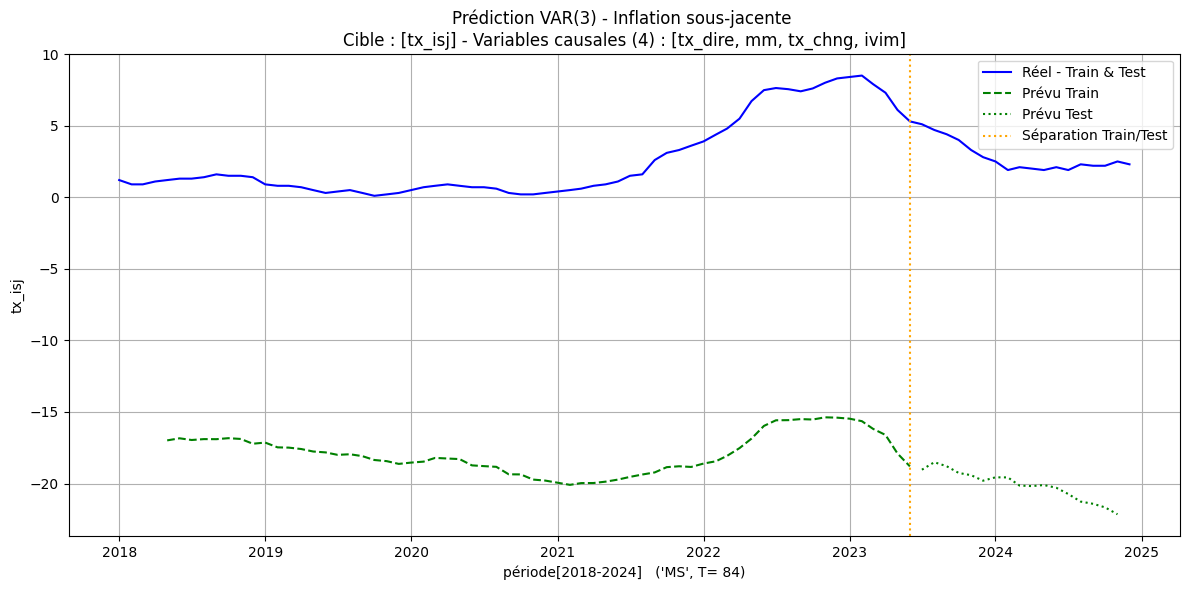

Diagnostics des résidus de 5 lags:
Autocorrélation des résidus :
	H_0: pasd’autocorrélation des résidus;
	H_1:présence d’autocorrélation des résidus
Hétéroscédasticité :
	H_0: variance constante (homoscédasticité);
	H_1:variance non constante (hétéroscédasticité)
Normalité des résidus :
	H_0: résidus suivent une loi normale;
	H_1:résidus ne suivent pas une loi normale
+----------------------------+-------+---------+----------------------------+
|            Test            | Stat  | p-value |          Décision          |
+----------------------------+-------+---------+----------------------------+
|  Ljung-Box (error, lag=1)  | 0.023 |  0.879  |     Ne pas rejeter H0      |
| Ljung-Box (error^2, lag=1) | 0.043 |  0.836  |     Ne pas rejeter H0      |
|    ARCH (nlags=1) – LM     | 0.041 |  0.84   |     Ne pas rejeter H0      |
|     ARCH (nlags=1) – F     | 0.039 |  0.844  |     Ne pas rejeter H0      |
|  Jarque–Bera (normalité)   | 48.49 |   0.0   | Rejeter H0 (non-normalité) |
+----

In [22]:
if len(df) == 0 or p_opt == 0 or p == 0:
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")

# 7 - Teste de causalité
test_causalite(df, p_opt)
df_stationnaire_reduit = df_stationnaire.drop(columns=non_causales)
split_index, train_reduit, test_reduit = split_data(df_stationnaire_reduit)
print(f"=> L'extraction des variables non-causale {non_causales} : Train {train_reduit.shape} et "\
       "Test {test_reduit.shape}")

# reRegression, reCalcul la matrice compagnon, et reTest la statbilité avec moins des variables (k=5)
B_est, Y_est, residus, Sigma_u, T, k,_ , _ = mco_multivariee(train_reduit, p_opt)
stability_system(matrice_compagonon(B_est, p_opt, k), p_opt)
df_reduit = df.drop(columns=non_causales)

# 8 - la prédiction
def pred_var(df_stat_reduit, df_reduit, p):
    T, k = df_stat_reduit.shape
    Y_pred = np.zeros((T, k))
    for t in range(p, T):
        y_pred_t = C.copy()
        for i in range(p): y_pred_t += A[i] @ df_reduit.values[t - i - 1].reshape(-1, 1)
        Y_pred[t] = y_pred_t.ravel()

    j = df_reduit.columns.get_loc(target) # Cible
    
    # Réel
    Y_train_real = df_reduit.values[:split_index, j]
    Y_test_real  = df_reduit.values[split_index:, j]   # vérifier d (décalage)

    Y_train_pred = Y_pred[:split_index, j]
    Y_test_pred  = Y_pred[split_index - d:, j]
    return Y_train_real, Y_train_pred, Y_test_real, Y_test_pred, residus

(train_real_man, train_pred_man, 
 test_real_man, test_pred_man, residus) = pred_var(df_stationnaire_reduit, df_reduit, p_opt)

# 9 - Calcul des métriques
metriques(f"=> Performance de l'implèmentation manuelle de VAR({p_opt}) T = {84 if freq=="MS" else 28}:", 
          train_real_man, train_pred_man, 
          test_real_man, test_pred_man)

# 10 - visualisation : 
causal_vars = [col for col in df_reduit.columns if col != target]
visualisation(f"Prédiction VAR({p_opt}) - Inflation sous-jacente \nCible : [{target}] - "
            f"Variables causales ({len(causal_vars)}) : [{', '.join(causal_vars)}]", 
              train_var, test_var,
              train_pred_man[p_opt+d:], test_pred_man[d:],
              [], [], 
              p_opt, d, freq)

# 11 - Validation de modèle : tester les violation des hypothèses des erreurs
error_isj = residus[:, df_reduit.columns.get_loc(target)]
residual_diagnostics(error_isj, 5)

##### 2.2. Utilisation de la bibliothèque VAR (statsmodels) model(6 et 8):

=> Performance de la Bibliothèque VAR(3) T = 84:
   Train : MSE=0.0367 | MAE=0.1410 | R²=0.7276
   Test  : MSE=0.1199 | MAE=0.2617 | R²=-0.2907


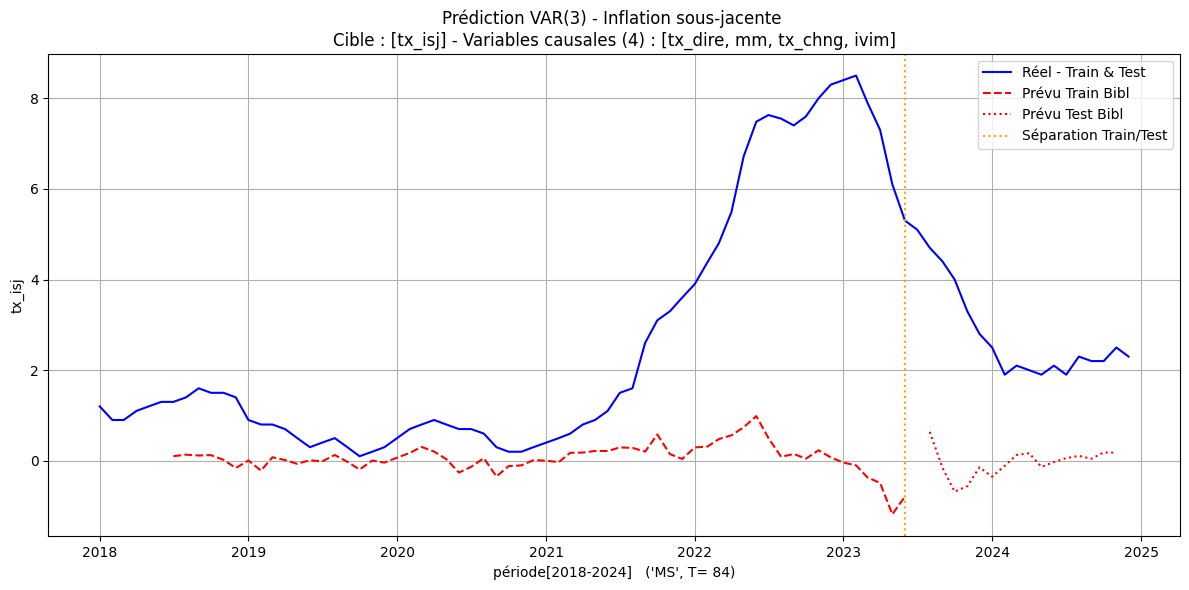

Diagnostics des résidus de 5 lags:
Autocorrélation des résidus :
	H_0: pasd’autocorrélation des résidus;
	H_1:présence d’autocorrélation des résidus
Hétéroscédasticité :
	H_0: variance constante (homoscédasticité);
	H_1:variance non constante (hétéroscédasticité)
Normalité des résidus :
	H_0: résidus suivent une loi normale;
	H_1:résidus ne suivent pas une loi normale
+----------------------------+-------+---------+----------------------------+
|            Test            | Stat  | p-value |          Décision          |
+----------------------------+-------+---------+----------------------------+
|  Ljung-Box (error, lag=1)  | 0.023 |  0.879  |     Ne pas rejeter H0      |
| Ljung-Box (error^2, lag=1) | 0.043 |  0.836  |     Ne pas rejeter H0      |
|    ARCH (nlags=1) – LM     | 0.041 |  0.84   |     Ne pas rejeter H0      |
|     ARCH (nlags=1) – F     | 0.039 |  0.844  |     Ne pas rejeter H0      |
|  Jarque–Bera (normalité)   | 48.49 |   0.0   | Rejeter H0 (non-normalité) |
+----

In [23]:
def bibl_var(p) : 
  if len(train_reduit) == 0 or p == 0:
    sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
  model_reduced = VAR(train_reduit)
  var_model = model_reduced.fit(p)

  train_pred = var_model.fittedvalues # Prédictions entraînement
  train_pred.index = train_reduit.index[var_model.k_ar:] # Ajuster l'index (VAR commence à p)
  # Prédictions test
  forecast = var_model.forecast(y=train_reduit.values, steps=len(test_reduit))
  forecast_df = pd.DataFrame(forecast, index=test_reduit.index, columns=train_reduit.columns)
  
  # Réintégration (retour à l’échelle originale)
  ind0 = train_reduit.index[0]
  last_known = df.loc[ind0]   # base pour cumsum
  train_pred_original = train_pred.cumsum() + last_known
  forecast_df_original = forecast_df.cumsum() + df.loc[train_reduit.index[-1]]

  # Récupérer la colonne cible dans les prédictions VAR
  target_train_real = train_reduit[target].iloc[var_model.k_ar:]
  target_test_real  = test_reduit[target]

  target_train_pred = train_pred[target]
  target_test_pred  = forecast_df[target]
  return (target_train_real, target_train_pred, 
          target_test_real, target_test_pred, 
          train_pred_original, forecast_df_original, var_model.resid)

(train_real_bibl, train_pred_bibl, 
 test_real_bibl, test_pred_bibl, 
 train_pred_orig, forecast_df_orig, resid) = bibl_var(p_opt)

metriques(f"=> Performance de la Bibliothèque VAR({p_opt}) T = {84 if freq=="MS" else 28}:", 
          train_real_bibl, 
          train_pred_bibl, 
          test_real_bibl, 
          test_pred_bibl)
# 10 - visualisation : 
causal_vars = [col for col in df_reduit.columns if col != target]
visualisation(f"Prédiction VAR({p_opt}) - Inflation sous-jacente \nCible : [{target}] - "
            f"Variables causales ({len(causal_vars)}) : [{', '.join(causal_vars)}]", 
              train_var, test_var,
              [], [],
              train_pred_bibl, test_pred_bibl, 
              p, d, freq)

# 11 - Validation de modèle : tester les violation des hypothèses des erreurs
residual_diagnostics(resid[target], 5)

# 12. Tester la capacité de modèle : sur t+k, k=1 'univariées' ou k=>1 'multivariées'
last_row = df_reduit[-p_opt:]
if freq == "MS" : 
    val = C[0]
    for i in range(0, p_opt) :
      val =+ last_row[i:i+1] @ A[i][0]

    # Modèle VAR Bibliothèque
    model_reduced = VAR(train_reduit)
    var_model = model_reduced.fit(p)
    history = train_reduit.values.copy()
    predictions = []
    for t in range(len(test_reduit)):
      forecast = var_model.forecast(y=history[-p:], steps=1)
      predictions.append(forecast[0])
      new_row = test_reduit.values[t].reshape(1, -1)  # reshape en 2D
      history = np.vstack([history, new_row])
      
    new_isj_pred = pd.DataFrame({
        "isj 2025" : [float(new_val_isj[0])],
        "Prévision Man": [round(float(val), 1)],
        "Prévision Bib": history[-1, 0]
    }, index=[futur_dates[0] + pd.offsets.MonthEnd(0)])
    print(f"La capacité de modèle de prévoir des valeurs futur hors dataset :\n {new_isj_pred}")

<p style="font-size:20px">Le modèle VAR(3) présente une performance insatisfaisante, nous décrémentons p et nous testons la causalité pour exclure plus des variables non-causale (-> un modèle paricimineux)</p>

====================================  p = 2  =====================================

Test de causalité de Granger : les variables causales et les lags qui correpondent p = 2
  variable  lag  p_value
0  tx_dire    1    0.000
1  tx_dire    2    0.030
2  tx_chng    1    0.000
3     ivim    1    0.011
Cst :  (4, 1)
A1  :  (4, 4)
A2  :  (4, 4)
=> Performance de l'implèmentation manuelle de VAR(2) T = 84 :
   Train : MSE=0.8525 | MAE=0.7975 | R²=0.8894
   Test  : MSE=0.7115 | MAE=0.7076 | R²=0.3114
=> Performance de la Bibliothèque VAR(2) T = 84 :
   Train : MSE=0.0520 | MAE=0.1554 | R²=0.6086
   Test  : MSE=0.0762 | MAE=0.2444 | R²=0.1794


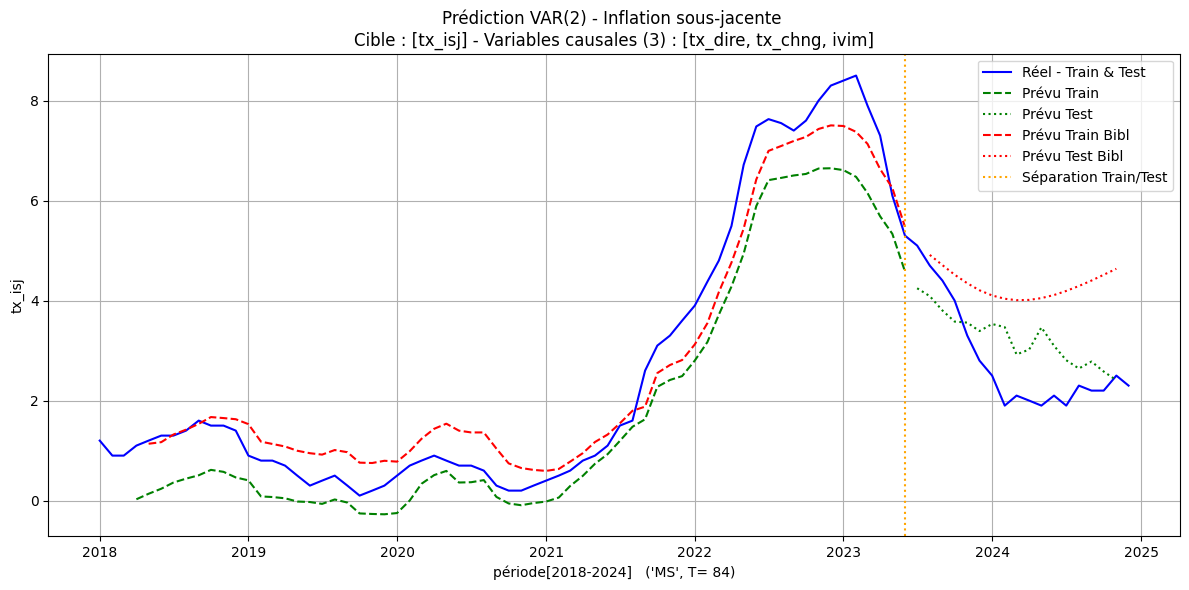

Diagnostics des résidus de 5 lags:
Autocorrélation des résidus :
	H_0: pasd’autocorrélation des résidus;
	H_1:présence d’autocorrélation des résidus
Hétéroscédasticité :
	H_0: variance constante (homoscédasticité);
	H_1:variance non constante (hétéroscédasticité)
Normalité des résidus :
	H_0: résidus suivent une loi normale;
	H_1:résidus ne suivent pas une loi normale
+----------------------------+--------+---------+----------------------------+
|            Test            |  Stat  | p-value |          Décision          |
+----------------------------+--------+---------+----------------------------+
|  Ljung-Box (error, lag=1)  | 0.016  |  0.898  |     Ne pas rejeter H0      |
| Ljung-Box (error^2, lag=1) | 0.175  |  0.676  |     Ne pas rejeter H0      |
|    ARCH (nlags=1) – LM     | 0.164  |  0.685  |     Ne pas rejeter H0      |
|     ARCH (nlags=1) – F     |  0.16  |  0.691  |     Ne pas rejeter H0      |
|  Jarque–Bera (normalité)   | 64.727 |   0.0   | Rejeter H0 (non-normalité)

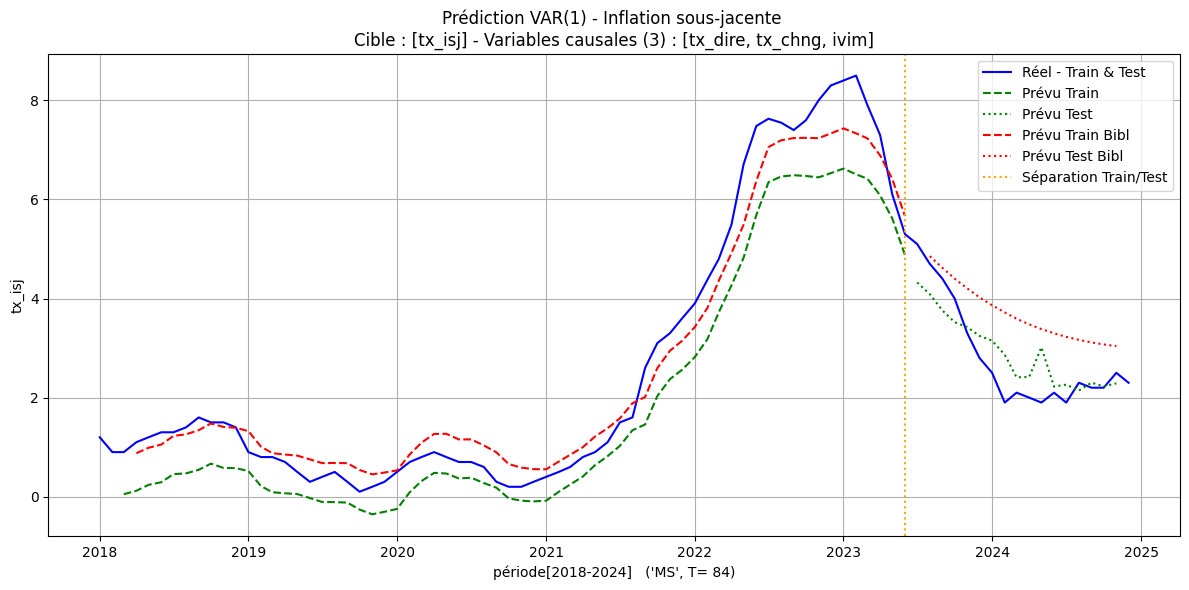

Diagnostics des résidus de 5 lags:
Autocorrélation des résidus :
	H_0: pasd’autocorrélation des résidus;
	H_1:présence d’autocorrélation des résidus
Hétéroscédasticité :
	H_0: variance constante (homoscédasticité);
	H_1:variance non constante (hétéroscédasticité)
Normalité des résidus :
	H_0: résidus suivent une loi normale;
	H_1:résidus ne suivent pas une loi normale
+----------------------------+--------+---------+----------------------------+
|            Test            |  Stat  | p-value |          Décision          |
+----------------------------+--------+---------+----------------------------+
|  Ljung-Box (error, lag=1)  |  0.26  |  0.61   |     Ne pas rejeter H0      |
| Ljung-Box (error^2, lag=1) | 0.117  |  0.732  |     Ne pas rejeter H0      |
|    ARCH (nlags=1) – LM     | 0.111  |  0.739  |     Ne pas rejeter H0      |
|     ARCH (nlags=1) – F     | 0.108  |  0.744  |     Ne pas rejeter H0      |
|  Jarque–Bera (normalité)   | 25.378 |   0.0   | Rejeter H0 (non-normalité)

In [24]:
if len(train_var) == 0 or p_opt == 0 or p == 0:
  sys.exit("Vous devez recompiler le code dés le début pour charger certains params !!")
if p_opt > 1 : p = p_opt - 1 
else : sys.exit("VAR(1) déja effectué !!")
for p in range(p, 0, -1):
  print(f"====================================  p = {p}  =====================================")
  test_causalite(train_var, p)
  df_stationnaire_reduit = df_stationnaire.drop(columns=non_causales)
  split_index, train_reduit, test_reduit = split_data(df_stationnaire_reduit)
  B_est, Y_est, residus, Sigma_u, T, k, _, _ = mco_multivariee(train_reduit, p)
  matrice_compagonon(B_est, p, k)
  df_reduit = df.drop(columns=non_causales)
  
  (train_real_man, train_pred_man, 
  test_real_man, test_pred_man, residus) = pred_var(df_stationnaire_reduit, df_reduit, p)

  metriques(f"=> Performance de l'implèmentation manuelle de VAR({p}) T = {84 if freq=="MS" else 28} :", 
            train_real_man, train_pred_man, 
            test_real_man, test_pred_man)
  
  (train_real_bibl, train_pred_bibl, 
  test_real_bibl, test_pred_bibl, 
  train_pred_orig, forecast_df_orig, _) = bibl_var(p)

  metriques(f"=> Performance de la Bibliothèque VAR({p}) T = {84 if freq=="MS" else 28} :", 
            train_real_bibl, train_pred_bibl, 
            test_real_bibl, test_pred_bibl)
  
  causal_vars = [col for col in df_reduit.columns if col != target]
  visualisation(f"Prédiction VAR({p}) - Inflation sous-jacente \nCible : [{target}] - "
              f"Variables causales ({len(causal_vars)}) : [{', '.join(causal_vars)}]", 
                train_var, test_var,
                train_pred_man[p+d:], test_pred_man[d:],
                train_pred_orig[target][d:], forecast_df_orig[target], 
                p, d, freq)
  # 12 - Validation de modèle : tester les violation des hypothèses des erreurs
  residual_diagnostics(residus[:, df_reduit.columns.get_loc(target)], 5)
  # 12. Tester la capacité de modèle : sur t+k, k>=1 'univariées' ou k=1 'multivariées'
  last_row = df_reduit[-p:]
  if freq == "MS" : 
      val = C[0]
      for i in range(0, p) :
          val =+ last_row[i:i+1] @ A[i][0]
      # Modèle VAR Bibliothèque
      model_reduced = VAR(train_reduit)
      var_model = model_reduced.fit(p)
      history = train_reduit.values.copy()
      predictions = []
      for t in range(len(test_reduit)):
        forecast = var_model.forecast(y=history[-p:], steps=1)
        predictions.append(forecast[0])
        new_row = test_reduit.values[t].reshape(1, -1)  # reshape en 2D
        history = np.vstack([history, new_row])
        
      new_isj_pred = pd.DataFrame({
          "isj 2025" : [float(new_val_isj[0])],
          "Prévision Man": [round(float(val), 1)],
          "Prévision Bib": history[-1, 0]
      }, index=[futur_dates[0] + pd.offsets.MonthEnd(0)])
      print(f"La capacité de modèle de prévoir des valeurs futur hors dataset :\n {new_isj_pred}")
  print("====================================================================================")

In [25]:
model_non_overfitting.append(7) # ajout pour le tableau d'analyse
model_overfitting.append(8) # ajout pour le tableau d'analyse

##### 2.3. Analyse :

<pre>
=> Performance de l'implèmentation manuelle de VAR(1) T = 28:
   Train : MSE=5.0867 | MAE=1.8160 | R²=0.1347
   Test  : MSE=9.8068 | MAE=2.9815 | R²=-1.0821
=> Performance de la Bibliothèque VAR(1) T = 28:
   Train : MSE=0.1358 | MAE=0.2887 | R²=0.8496
   Test  : MSE=1.1679 | MAE=0.8743 | R²=-1.6054

=> Performance de l'implèmentation manuelle de VAR(1) T = 84 :
   Train : MSE=0.8366 | MAE=0.7935 | R²=0.8915
   Test  : MSE=0.2753 | MAE=0.4113 | R²=0.7336
=> Performance de la Bibliothèque VAR(1) T = 84 :
   Train : MSE=0.0575 | MAE=0.1706 | R²=0.5608
   Test  : MSE=0.0709 | MAE=0.2136 | R²=0.2362
</pre>
Le modél VAR d'ordre 1 avec échantillon réduit (T=28) n'a pas donnée de resultat satisfaisant, une augmentation de nombre d'observation, le modéle a pu apprendre et généraliser mais moins perforamant :<br/>
nous avons passé de VAR(3) qui n a pas pu expliquer la variabilité des données (moins performant qu'une moyenne), puis p=2, moins perforant puis p = 1, qui a donnée un résultat moins perforamnt mais prometeuse.
</br>
Le modèle VAR a pu capturer la dynamique structurelle de l'inflation sous-jacente en détectant le variables qui impacte directement l'inflation sous-jacente (déctection d'interdépendances linéaires) à savoir :<br/>
le taux directeur : instrument de la politique monétaire 
le tx de change : dans un régime de change fixe, la variation du taux de change n’a pas un grand effet sur l’inflation. En revanche, dans un régime de change flottant, ses fluctuations peuvent dynamiser ou accentuer l’inflation. 
l'indice des valeur à l'importation : Suivre l’inflation importée.
Nous devons chercher à présent d'autre relation existant entre les variables et leurs passées.



#### 🔹3. Réseau de Neurones (RNA)

##### 3.1 - Implèmenation manuelle (model : 9, 11, 13, 15, 17, 19):

In [26]:
freq = "MS" # {"MS"|"QS"}  échantillon: {étendu|reduit} Freq: {Mensuelle|Trimestrielle}
df, new_val_isj, futur_dates = reload_data(freq) 
target = 'tx_isj'

In [72]:
# Sélection des variables
k = 1  # à changer  {1|4|7}  {univarié|multivarié simple|multivarié complexe}

target = 'tx_isj'
if k == 1 : variables = ['tx_isj']
elif k == 4 : variables = ['tx_isj', 'tx_chng', 'tx_dire', 'ivim']
else: variables = ['tx_isj', 'mm', 'tx_dire', 'tx_chng', 'tx_chmg', 'tx_croi', 'ivim']

# 1 - préparation des données : {(label, features)} selon les retards p
p = 1
for var in variables: 
    columns = [] 
    for lag in range(1, p + 1):  
        df[f"{var}_t-{lag}"] = df[var].shift(lag)

df_clean = df.dropna()# Nettoyage

# Préparation X et y
X_columns = [f"{var}_t-{lag}" for var in variables for lag in range(1, p + 1)]
X = df_clean[X_columns].values # les features 
y = df_clean['tx_isj'].values.reshape(-1, 1) # le label

# 2 - Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"features (Entrainement) : {X_train.shape}, label (Entrainement) : {y_train.shape}")
print(f"features (Teste)        : {X_test.shape}, label (Teste)        : {y_test.shape}")

# 3 - Normalisation | Standarisation
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

features (Entrainement) : (66, 1), label (Entrainement) : (66, 1)
features (Teste)        : (17, 1), label (Teste)        : (17, 1)


In [28]:
# 2 - Initialisation du modèle
T, k = X_train_scaled.shape

h = 4  # Nombre de neurones cachés 

np.random.seed(0)
W1 = np.random.randn(k, h) * np.sqrt(2 / k)
b1 = np.zeros((1, h))
W2 = np.random.randn(h, 1) * np.sqrt(2 / h)
b2 = np.zeros((1, 1))

# Fonctions d'activation
def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return (x > 0).astype(float)

# Entraînement
epochs = 2500
lr = 0.075

patience = 10
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(epochs):
    # === la propagation ===
    Z1 = X_train_scaled @ W1 + b1
    
    A1 = relu(Z1)
    y_pred = A1 @ W2 + b2

    # L1 + L2 regularisation (on peut garder L1+L2 ensemble = régularisation mixte)
    lambda_l2 = 0.01
    lambda_l1 = 0.01
    l2_reg = lambda_l2 * (np.sum(W1**2) + np.sum(W2**2)) # rég. ridge
    l1_reg = lambda_l1 * (np.sum(np.abs(W1)) + np.sum(np.abs(W2))) #rég. lasso
    loss = np.mean((y_train_scaled - y_pred)**2) + l2_reg + l1_reg # mse + rég.

    # === la rétro-propagation ===
    dL = 2 / T * (y_pred - y_train_scaled) # d/d{y_pred}(mse)
    dW2 = A1.T @ dL + 2*lambda_l2*W2 + lambda_l1*np.sign(W2)
    db2 = np.sum(dL, axis=0, keepdims=True)
    dA1 = dL @ W2.T
    dZ1 = dA1 * relu_deriv(Z1)
    dW1 = X_train_scaled.T @ dZ1 + 2*lambda_l2*W1 + lambda_l1*np.sign(W1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    # Mise à jour des poids
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2

    # === Forward (validation) ===
    Z1_val = X_train_scaled @ W1 + b1
    A1_val = relu(Z1_val)
    y_val_pred = A1_val @ W2 + b2
    val_loss = np.mean((y_train_scaled - y_val_pred)**2) + \
               lambda_l2 * (np.sum(W1**2) + np.sum(W2**2)) + \
               lambda_l1 * (np.sum(np.abs(W1)) + np.sum(np.abs(W2)))

    # === Early stopping ===
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # sauvegarde des poids
        best_W1, best_b1 = W1.copy(), b1.copy()
        best_W2, best_b2 = W2.copy(), b2.copy()
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping à l'epoch {epoch+1}")
        break

    if epoch % 50 == 0:
        print(f"Epoch {epoch:3d} | Train Loss: {loss:.5f} | Val Loss: {val_loss:.5f}")

# Restaure les meilleurs poids
W1, b1 = best_W1, best_b1
W2, b2 = best_W2, best_b2

Epoch   0 | Train Loss: 5.10222 | Val Loss: 7.73820
Epoch  50 | Train Loss: 0.25712 | Val Loss: 0.25619
Epoch 100 | Train Loss: 0.21339 | Val Loss: 0.21269
Epoch 150 | Train Loss: 0.18368 | Val Loss: 0.18317
Epoch 200 | Train Loss: 0.16040 | Val Loss: 0.15986
Epoch 250 | Train Loss: 0.12985 | Val Loss: 0.12931
Epoch 300 | Train Loss: 0.10978 | Val Loss: 0.10951
Epoch 350 | Train Loss: 0.09913 | Val Loss: 0.09895
Epoch 400 | Train Loss: 0.09176 | Val Loss: 0.09163
Epoch 450 | Train Loss: 0.08594 | Val Loss: 0.08583
Epoch 500 | Train Loss: 0.08105 | Val Loss: 0.08097
Epoch 550 | Train Loss: 0.07712 | Val Loss: 0.07705
Epoch 600 | Train Loss: 0.07409 | Val Loss: 0.07403
Epoch 650 | Train Loss: 0.07142 | Val Loss: 0.07135
Epoch 700 | Train Loss: 0.06902 | Val Loss: 0.06896
Epoch 750 | Train Loss: 0.06686 | Val Loss: 0.06681
Epoch 800 | Train Loss: 0.06490 | Val Loss: 0.06485
Epoch 850 | Train Loss: 0.06308 | Val Loss: 0.06304
Epoch 900 | Train Loss: 0.06140 | Val Loss: 0.06135
Epoch 950 | 

In [29]:
# 4 - Prédictions :
# sur train
Z1_train = X_train_scaled @ W1 + b1
A1_train = relu(Z1_train)
y_train_pred_scaled = A1_train @ W2 + b2
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled).flatten()

# sur test
Z1_test = X_test_scaled @ W1 + b1
A1_test = relu(Z1_test)
y_test_pred_scaled = A1_test @ W2 + b2
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled).flatten()

In [30]:
# 5 - Calcul des métriques
metriques(f"=> Performance de l'implèmentation manuelle de RNA(k = {k}, p = {p}, h = {h})"\
          f" T = {84 if freq=="MS" else 28}:", 
          y_train, y_train_pred, 
          y_test, y_test_pred)

=> Performance de l'implèmentation manuelle de RNA(k = 1, p = 1, h = 4) T = 84:
   Train : MSE=0.1324 | MAE=0.2454 | R²=0.9830
   Test  : MSE=0.1332 | MAE=0.3150 | R²=0.8251


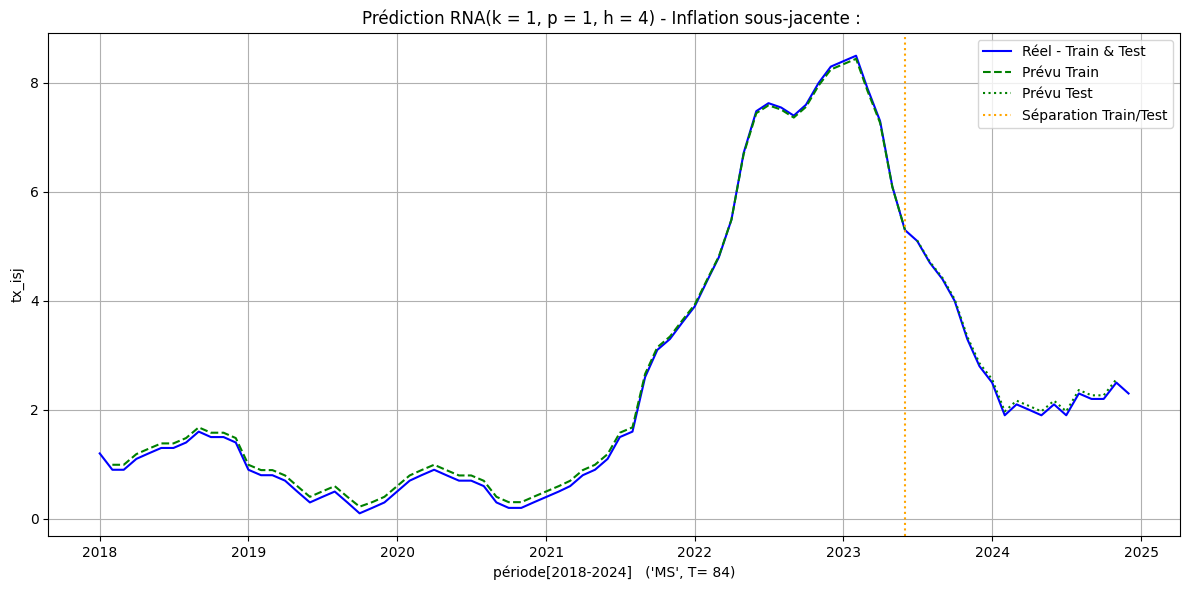

In [31]:
# 6 - Présentation graphique valeurs réelles vs valeurs prédites
visualisation(f"Prédiction RNA(k = {k}, p = {p}, h = {h}) - Inflation sous-jacente : ", 
                y_train, y_test,
                y_train_pred[p:], y_test_pred,
                [], [], 
                p, 0, freq)

In [32]:
# 7 - # Prévision t+k en dehors dataset pour p = 1
last_row = df[variables].iloc[[-1]].copy()
new_isj_pred = []
if freq == "MS" and  p == 1:   
    for i in range(len(new_val_isj) if k == 1 else 1):
        last_row_scaled = scaler_X.transform(last_row)
        # forward pass du réseau
        Z1 = last_row_scaled @ W1 + b1
        A1 = np.maximum(0, Z1)  # ReLU
        y_scaled = A1 @ W2 + b2

        y_pred = float(scaler_y.inverse_transform(y_scaled)[0, 0])

        new_isj_pred.append({
            "isj 2025": float(new_val_isj[i]), 
            "Prévision": round(y_pred, 1),
            "Date": futur_dates[i] + pd.offsets.MonthEnd(1)
        })
        last_row = last_row.copy()
        last_row[target] = new_val_isj[i]


    df_pred = pd.DataFrame(new_isj_pred).set_index("Date")
    mse = mean_squared_error(df_pred["isj 2025"], df_pred["Prévision"])
    r2 = r2_score(df_pred["isj 2025"], df_pred["Prévision"])
    print(f"La capacité de modèle de prévoir des valeurs futur hors dataset - '{freq}' k = {k}" \
          f" :\n {df_pred} \n mse = {round(mse, 3)} \n r² = {round(r2, 3)}")

La capacité de modèle de prévoir des valeurs futur hors dataset - 'MS' k = 1 :
             isj 2025  Prévision
Date                           
2025-01-31       2.3        2.4
2025-02-28       2.2        2.4
2025-03-31       1.4        2.3
2025-04-30       1.0        1.5
2025-05-31       1.0        1.1
2025-06-30       1.0        1.1
2025-07-31       0.8        1.1
2025-08-31       0.6        0.9 
 mse = 0.164 
 r² = 0.537


In [33]:
model_non_overfitting.append(15)
model_overfitting.append(17)
model_overfitting.append(19)

##### 3.2. Utilisation de la bibliothéque (model 10, 12, 14, 16, 18, 20): 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
=> Performance de la bibliothèque de RNA(k = 1, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.1299 | MAE=0.2360 | R²=0.9833
   Test  : MSE=0.3620 | MAE=0.5022 | R²=0.5245


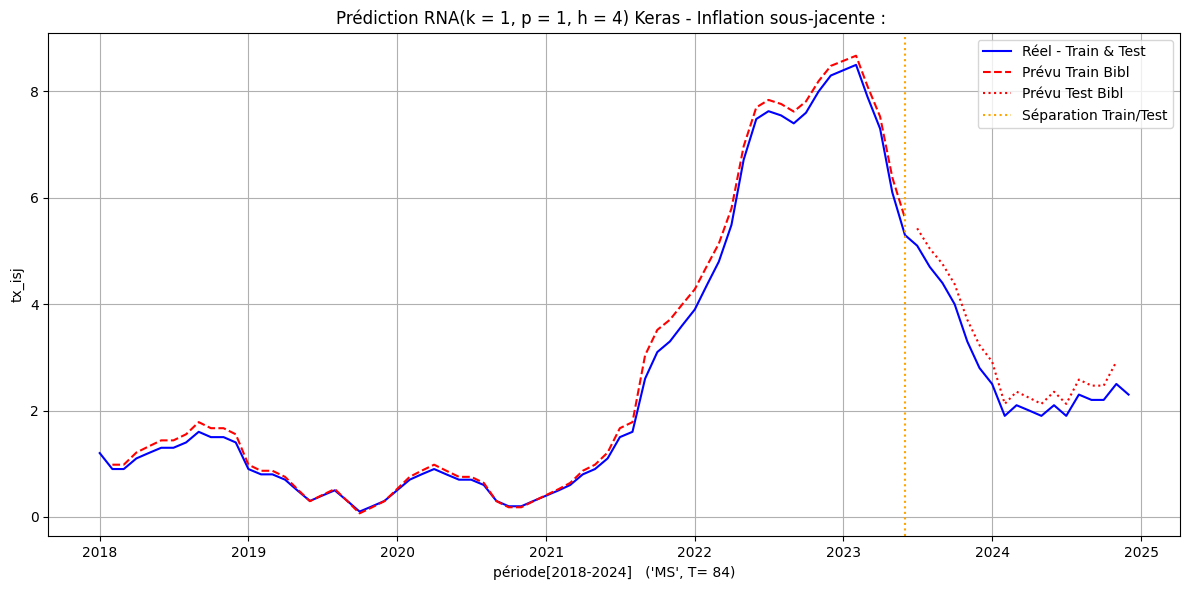

La capacité de modèle de prévoir des valeurs futur hors dataset - 'MS' k = 1 :
             isj 2025  Prévision
Date                           
2025-01-31       2.3        2.6
2025-02-28       2.2        3.0
2025-03-31       1.4        3.4
2025-04-30       1.0        3.8
2025-05-31       1.0        4.2
2025-06-30       1.0        4.6
2025-07-31       0.8        4.9
2025-08-31       0.6        5.3 
 mse = 9.334 
 r² = -25.397


In [34]:
# L'utilisation du Bibliothèque Kersa de tensorflow
# Conversion tensorflow/keras

# 1 - Fixer toutes les graines (pour poids, données, etc.){pour reproduire les mêmes resultats}
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)# contrôle les poids initiaux et les opérations aléatoires internes
random.seed(seed)

# 2 - Définir un initialiseur déterministe
initializer = keras.initializers.GlorotUniform(seed=seed)# fixe l’aléa d’initialisation des poids

model = keras.Sequential([
    keras.layers.Dense(
        h,
        activation='relu',
        input_shape=(X_train.shape[1],),
        kernel_initializer=initializer,  # pour 
        bias_initializer='zeros'         # optionnel (par défaut 0)
    ),
    keras.layers.Dense(
        1,
        kernel_initializer=initializer,  #
        bias_initializer='zeros'
    )
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss='mse')
# Entraînement
model.fit(X_train_scaled, y_train_scaled, epochs=epochs, verbose=0)

# Prédictions
y_train_pred_keras = scaler_y.inverse_transform(model.predict(X_train_scaled)).ravel()
y_test_pred_keras  = scaler_y.inverse_transform(model.predict(X_test_scaled)).ravel()

metriques(f"=> Performance de la bibliothèque de RNA(k = {k}, p = {p}, h = {h}) "\
          f"- Keras T = {84 if freq=="MS" else 28}:", 
          y_train, y_train_pred_keras, 
          y_test, y_test_pred_keras)

visualisation(f"Prédiction RNA(k = {k}, p = {p}, h = {h}) Keras - Inflation sous-jacente : ", 
                y_train, y_test, 
                [], [],
                y_train_pred_keras[p:], y_test_pred_keras, 
                p, 0, freq)

# Prévision t+k en dehors dataset pour p = 1
last_row = df[variables][len(df)-1:len(df)]
new_isj_pred = []
if freq == "MS" and p == 1: 
    for i in range(0, len(new_val_isj) if k == 1 else 1) :
        last_row_scaled = scaler_X.transform(last_row)
        y_pred_scaled = model.predict(last_row_scaled, verbose=0)
        last_row = scaler_y.inverse_transform(y_pred_scaled)[0, 0].reshape(1, -1)
        new_isj_pred.append({
            "isj 2025" : float(new_val_isj[i]),
            "Prévision": round(float(last_row), 1),
            "Date": futur_dates[i] + pd.offsets.MonthEnd(1)
        })
        

    df_pred = pd.DataFrame(new_isj_pred).set_index("Date")
    mse = mean_squared_error(df_pred["isj 2025"], df_pred["Prévision"])
    r2 = r2_score(df_pred["isj 2025"], df_pred["Prévision"])
    print(f"La capacité de modèle de prévoir des valeurs futur hors dataset - '{freq}' k = {k}" \
          f" :\n {df_pred} \n mse = {round(mse, 3)} \n r² = {round(r2, 3)}")

In [35]:
# ajout pour le tableau d'analyse
model_overfitting.append(16) 
model_non_overfitting.append(18)
model_overfitting.append(20)

=> Performance de l'implèmentation manuelle de RNA(k = 1, p = 1, h = 4) T = 84:
   Train : MSE=0.1324 | MAE=0.2454 | R²=0.9830
   Test  : MSE=0.1332 | MAE=0.3150 | R²=0.8251
=> Performance de la bibliothèque de RNA(k = 1, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.1299 | MAE=0.2360 | R²=0.9833
   Test  : MSE=0.3620 | MAE=0.5022 | R²=0.5245


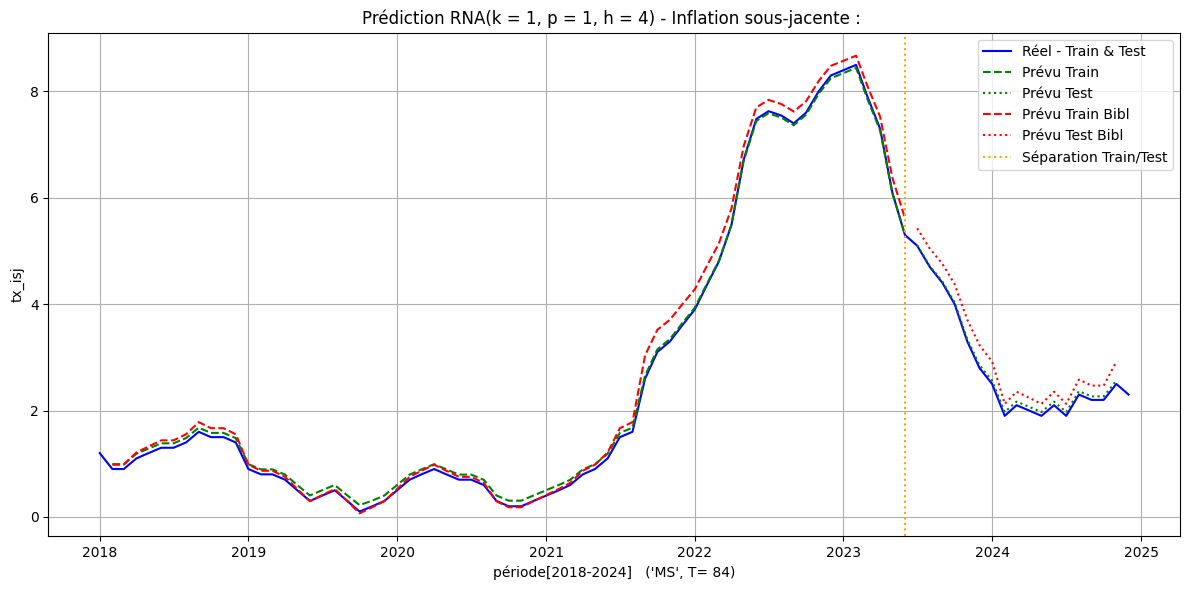

In [36]:
# 4 - Calcul des métriques
metriques(f"=> Performance de l'implèmentation manuelle de RNA(k = {k}, p = {p}, h = {h}) "\
          f"T = {84 if freq=="MS" else 28}:", 
          y_train, y_train_pred, 
          y_test, y_test_pred)

metriques(f"=> Performance de la bibliothèque de RNA(k = {k}, p = {p}, h = {h}) - Keras "\
          f"T = {84 if freq=="MS" else 28}:", 
          y_train, y_train_pred_keras, 
          y_test, y_test_pred_keras)

visualisation(f"Prédiction RNA(k = {k}, p = {p}, h = {h}) - Inflation sous-jacente : ",
                y_train, y_test, 
                y_train_pred[p:], y_test_pred,
                y_train_pred_keras[p:], y_test_pred_keras, 
                p, 0, freq)


##### 3.3. Analyse :

<pre>
=> Performance de l'implèmentation manuelle de RNA(k = 1, p = 1, h = 4) T = 28:
   Train : MSE=0.4179 | MAE=0.4920 | R²=0.9468
   Test  : MSE=2.4221 | MAE=1.2937 | R²=-1.5223
=> Performance de la bibliothèque de RNA(k = 1, p = 1, h = 4) - Keras T = 28:
   Train : MSE=0.2956 | MAE=0.4173 | R²=0.9624
   Test  : MSE=4.6155 | MAE=1.7051 | R²=-3.8066

=> Performance de l'implèmentation manuelle de RNA(k = 4, p = 1, h = 4) T = 28:
   Train : MSE=0.1169 | MAE=0.2838 | R²=0.9851
   Test  : MSE=1.0545 | MAE=0.8210 | R²=-0.0981
=> Performance de la bibliothèque de RNA(k = 4, p = 1, h = 4) - Keras T = 28:
   Train : MSE=0.0728 | MAE=0.2044 | R²=0.9907
   Test  : MSE=2.3715 | MAE=1.1869 | R²=-1.4697

=> Performance de l'implèmentation manuelle de RNA(k = 7, p = 1, h = 4) T = 28:
   Train : MSE=0.1415 | MAE=0.3196 | R²=0.9820
   Test  : MSE=7.2124 | MAE=2.5251 | R²=-6.5110
=> Performance de la bibliothèque de RNA(k = 7, p = 1, h = 4) - Keras T = 28:
   Train : MSE=0.0128 | MAE=0.0948 | R²=0.9984
   Test  : MSE=9.2059 | MAE=2.8767 | R²=-8.5870

=> Performance de l'implèmentation manuelle de RNA(k = 1, p = 1, h = 4) T = 84:
   Train : MSE=0.1324 | MAE=0.2454 | R²=0.9830
   Test  : MSE=0.1332 | MAE=0.3150 | R²=0.8251
=> Performance de la bibliothèque de RNA(k = 1, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.1300 | MAE=0.2361 | R²=0.9833
   Test  : MSE=0.3612 | MAE=0.5019 | R²=0.5256
   
=> Performance de l'implèmentation manuelle de RNA(k = 4, p = 1, h = 4) T = 84:
   Train : MSE=0.0678 | MAE=0.1999 | R²=0.9913
   Test  : MSE=0.5655 | MAE=0.6693 | R²=0.2572
=> Performance de la bibliothèque de RNA(k = 4, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.0452 | MAE=0.1571 | R²=0.9942
   Test  : MSE=0.2219 | MAE=0.3447 | R²=0.7086
   
=> Performance de l'implèmentation manuelle de RNA(k = 7, p = 1, h = 4) T = 84:
   Train : MSE=0.0635 | MAE=0.1917 | R²=0.9918
   Test  : MSE=0.5109 | MAE=0.6224 | R²=0.3289
=> Performance de la bibliothèque de RNA(k = 7, p = 1, h = 4) - Keras T = 84:
   Train : MSE=0.0323 | MAE=0.1403 | R²=0.9958
   Test  : MSE=0.3418 | MAE=0.5248 | R²=0.5510
</pre>

Sur un échantillon réduit, le modéle RNA n'a pas pu généralisée, le modèle mémorise les données d’entraînement, ce qui se traduit par un R² très élevé sur l’échantillon d’apprentissage mais négatif sur l’échantillon de test. 

Sur un échantillon étendu, et en s’appuyant uniquement sur les données passées de l’ISJ, l’implémentation manuelle du RNA a donné de bons résultats, avec un MSE quasi constant entre l’entraînement et le test et seulement une légère baisse du R². En revanche, la bibliothèque Keras s’est révélée moins performante. Lorsqu’on utilise des données multivariées, qu’elles soient simples ou complexes, bien que les R² demeurent positifs, on observe une forte augmentation du MSE entre l’entraînement et le test, ce qui constitue un signe de sur-apprentissage.


#### 🔹 4. XGBoost :

In [68]:
# Initialisation
freq = "MS" # {"MS"|"QS"}  échantillon: {étendu|reduit} Freq: {Mensuelle|Trimestrielle}
df, new_val_isj, futur_dates = reload_data(freq) 
target = 'tx_isj'

p = 1
k = 7 # à changer {1|4|7}  {univarié|multivarié simple|multivarié complexe}

if k == 1 : variables = ['tx_isj']
elif k == 4 : variables = ['tx_isj', 'tx_chng', 'tx_dire', 'ivim']
else: variables = ['tx_isj', 'mm', 'tx_dire', 'tx_chng', 'tx_chmg', 'tx_croi', 'ivim']

##### 4.1 - Implèmenation manuelle (model : 21, 23, 25, 27, 29, 31):

In [38]:
# 1 - préparation des données : {(label, features)} selon les retards p
for var in variables: 
    columns = [] 
    for lag in range(1, p + 1):  
        df[f"{var}_t-{lag}"] = df[var].shift(lag)

df_clean = df.dropna()# Nettoyage

# Préparation X et y
X_columns = [f"{var}_t-{lag}" for var in variables for lag in range(1, p + 1)]
X = df_clean[X_columns].values # les features 
y = df_clean['tx_isj'].values.reshape(-1, 1) # le label

# 2 - Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(f"features (Entrainement) : {X_train.shape}, label (Entrainement) : {y_train.shape}")
print(f"features (Teste)        : {X_test.shape}, label (Teste)        : {y_test.shape}")

features (Entrainement) : (66, 7), label (Entrainement) : (66, 1)
features (Teste)        : (17, 7), label (Teste)        : (17, 1)


In [39]:
# 3 - Initialisation des paramétres d'entrainement
F_0 = np.mean(y_train)  # moyenne des données d'entraînement
F_t_train = np.full_like(y_train, F_0)
trees = []
learning_rate = 0.01
n_estimators = 1000

patience = 5  # Nombre d'itérations sans amélioration tolérées
min_delta = 1e-5  # Amélioration minimale du MSE
best_val_mse = float('inf')
patience_counter = 0

lambda_reg = 0.01

# 4. Boosting : entraînement sur le train
for t in range(n_estimators):
    # Gradient et Hessien
    g = F_t_train - y_train  # Gradient
    h = np.ones_like(g)      # Hessien constant (MSE)

    # Pseudo-résidus
    pseudo_residual = -g / h

    # Arbre sur les résidus
    tree = DecisionTreeRegressor(max_depth=3, random_state=42)
    tree.fit(X_train, pseudo_residual)
    update = tree.predict(X_train)
    
    # Mise à jour
    update = update.reshape(-1,1)
    F_t_train += learning_rate * update
    trees.append(tree)

    # MSE d'entraînement
    mse = mean_squared_error(y_train, F_t_train) # sans régularisation
    mse = mean_squared_error(y_train, F_t_train) + lambda_reg * np.sum(update**2)
    print(f"Iteration {t+1} - Train MSE: {mse:.4f}")

    # Early stopping
    if mse + min_delta < best_val_mse:
        best_val_mse = mse
        best_iteration = t
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping à l'itération {t+1} (meilleur " \
                  f"Val MSE = {best_val_mse:.4f} à l’itération {best_iteration+1})")
            break

Iteration 1 - Train MSE: 12.7063
Iteration 2 - Train MSE: 12.4549
Iteration 3 - Train MSE: 12.2084
Iteration 4 - Train MSE: 11.9668
Iteration 5 - Train MSE: 11.7300
Iteration 6 - Train MSE: 11.4980
Iteration 7 - Train MSE: 11.2705
Iteration 8 - Train MSE: 11.0470
Iteration 9 - Train MSE: 10.8294
Iteration 10 - Train MSE: 10.6154
Iteration 11 - Train MSE: 10.4050
Iteration 12 - Train MSE: 10.2004
Iteration 13 - Train MSE: 9.9982
Iteration 14 - Train MSE: 9.8016
Iteration 15 - Train MSE: 9.6079
Iteration 16 - Train MSE: 9.4179
Iteration 17 - Train MSE: 9.2324
Iteration 18 - Train MSE: 9.0502
Iteration 19 - Train MSE: 8.8713
Iteration 20 - Train MSE: 8.6967
Iteration 21 - Train MSE: 8.5252
Iteration 22 - Train MSE: 8.3566
Iteration 23 - Train MSE: 8.1923
Iteration 24 - Train MSE: 8.0306
Iteration 25 - Train MSE: 7.8721
Iteration 26 - Train MSE: 7.7171
Iteration 27 - Train MSE: 7.5650
Iteration 28 - Train MSE: 7.4157
Iteration 29 - Train MSE: 7.2697
Iteration 30 - Train MSE: 7.1266
Iterati

In [40]:
# 5. Fonction de prédiction finale
def predict_boosted(X_input, trees, F_0, lr):
    y_hat = np.full(X_input.shape[0], F_0)
    for tree in trees:
        y_hat += lr * tree.predict(X_input)
    return y_hat

y_train_pred = predict_boosted(X_train, trees, F_0, learning_rate)
y_test_pred = predict_boosted(X_test, trees, F_0, learning_rate)

In [41]:
# 6 - Calcul des métriques
metriques(f"=> Performance de l'implèmentation manuelle de XGBoost(k = {k}, "\
          f"p = {p}, T = {84 if freq=="MS" else 28}) :", 
          y_train, y_train_pred, 
          y_test, y_test_pred)

=> Performance de l'implèmentation manuelle de XGBoost(k = 7, p = 1, T = 84) :
   Train : MSE=0.0018 | MAE=0.0329 | R²=0.9998
   Test  : MSE=2.5111 | MAE=1.4811 | R²=-2.2984


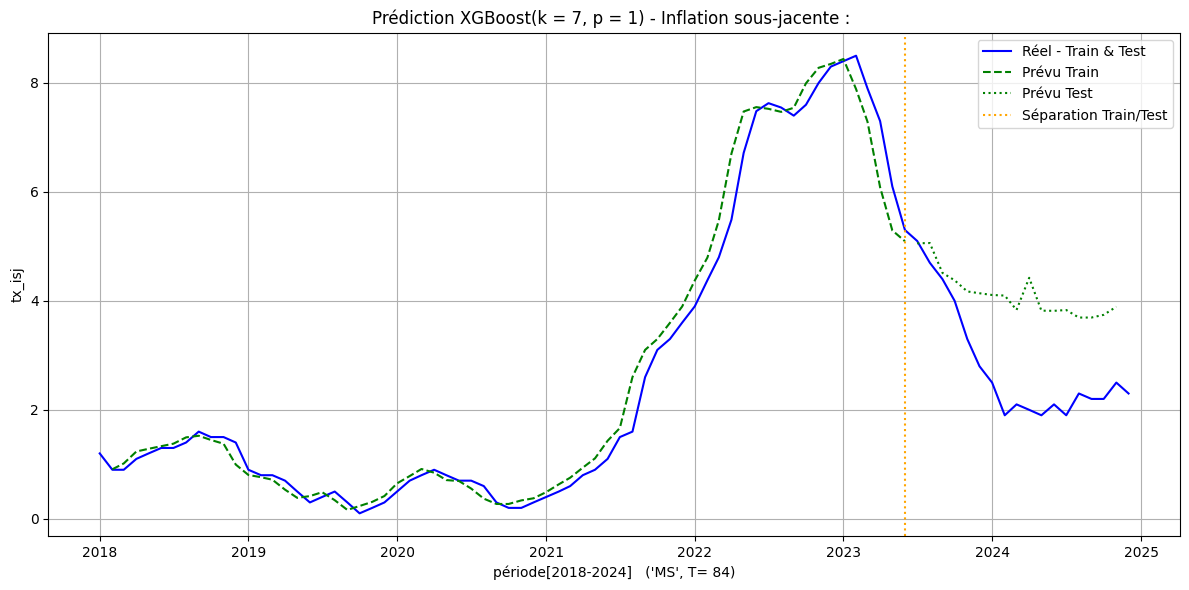

In [42]:
# 7 - 
visualisation(f"Prédiction XGBoost(k = {k}, p = {p}) - Inflation sous-jacente : ", 
                y_train, y_test,
                y_train_pred[p:], y_test_pred,
                [], [], 
                p, 0, freq)

In [43]:
# Prévision t+k en dehors dataset pour p = 1
last_row = df[variables][len(df)-1:len(df)]
new_isj_pred = []

if freq == "MS" and p==1 : 
    for i in range(0, len(new_val_isj) if k==1 else 1) :
        y_pred = predict_boosted(last_row, trees, F_0, lr)
        new_isj_pred.append({
            "isj 2025" : new_val_isj[i],
            "Prévision": round(float(y_pred), 1),
            "Date": futur_dates[i] + pd.offsets.MonthEnd(1)
        })
        last_row = pd.DataFrame({"tx_isj" : new_val_isj[i]}, index=[futur_dates[i]])
    

    df_pred = pd.DataFrame(new_isj_pred).set_index("Date")
    mse = mean_squared_error(df_pred["isj 2025"], df_pred["Prévision"])
    r2 = r2_score(df_pred["isj 2025"], df_pred["Prévision"])
    print(f"La capacité de modèle de prévoir des valeurs futur hors dataset - '{freq}' k = {k}" \
          f" :\n {df_pred} \n mse = {round(mse, 3)} \n r² = {round(r2, 3)}")

La capacité de modèle de prévoir des valeurs futur hors dataset - 'MS' k = 7 :
             isj 2025  Prévision
Date                           
2025-01-31       2.3       12.0 
 mse = 94.09 
 r² = nan


In [44]:
model_overfitting.append(27)

##### 4.2. Utilisation de la bibliothéque - XGBRegressor (model : 22, 24, 26, 28, 30, 32) :

=> Performance de la bibliothèque XGBRegressor de XGBoost(k = 7, p = 1, T = 84) :
   Train : MSE=0.0010 | MAE=0.0239 | R²=0.9999
   Test  : MSE=0.3416 | MAE=0.5336 | R²=0.5513


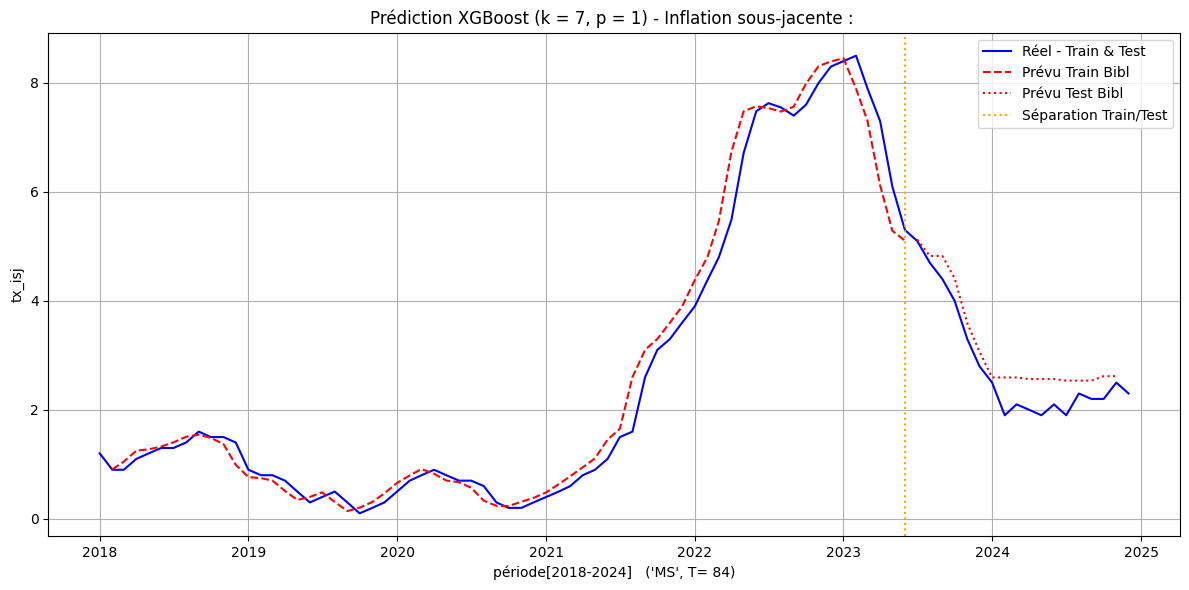

La capacité de modèle de prévoir des valeurs futur hors dataset - 'MS' k = 7 :
             isj 2025  Prévision
Date                           
2025-01-31       2.3        2.6 
 mse = 0.09 
 r² = nan


In [45]:
# l'utilisation de bibliothèque : XGBRegressor
model = XGBRegressor(
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)
# Prédictions
y_train_pred_bibl = model.predict(X_train)
y_test_pred_bibl = model.predict(X_test)

metriques(f"=> Performance de la bibliothèque XGBRegressor de XGBoost(k = {k}, "\
          f"p = {p}, T = {84 if freq=="MS" else 28}) :", 
          y_train, y_train_pred_bibl,
          y_test, y_test_pred_bibl)

visualisation(f"Prédiction XGBoost (k = {k}, p = {p}) - Inflation sous-jacente : ", 
                y_train, y_test,
                [], [],
                y_train_pred_bibl[p:], y_test_pred_bibl, 
                p, 0, freq)

# Prévision t+k en dehors dataset pour p = 1
last_row = df[variables][len(df)-1:len(df)]
new_isj_pred = []
if freq == "MS" and p==1 : 
    for i in range(0, len(new_val_isj) if k==1 else 1) :
        y_pred = model.predict(last_row, new_val_isj[i])
        new_isj_pred.append({
            "isj 2025" : new_val_isj[i],
            "Prévision": round(float(y_pred), 1),
            "Date": futur_dates[i] + pd.offsets.MonthEnd(1)
        })
        last_row = new_val_isj[i]

    df_pred = pd.DataFrame(new_isj_pred).set_index("Date")
    mse = mean_squared_error(df_pred["isj 2025"], df_pred["Prévision"])
    r2 = r2_score(df_pred["isj 2025"], df_pred["Prévision"])
    print(f"La capacité de modèle de prévoir des valeurs futur hors dataset - '{freq}' k = {k}" \
          f" :\n {df_pred} \n mse = {round(mse, 3)} \n r² = {round(r2, 3)}")

In [46]:
# ajout pour le tableau d'analyse
model_non_overfitting.append(28)
model_non_overfitting.append(30)
model_non_overfitting.append(32)

=> Performance de l'implèmentation manuelle de XGBoost(k = 7, p = 1, T = 84) :
   Train : MSE=0.0018 | MAE=0.0329 | R²=0.9998
   Test  : MSE=2.5111 | MAE=1.4811 | R²=-2.2984
=> Performance de la bibliothèque XGBRegressor de XGBoost(k = 7, p = 1, T = 84) :
   Train : MSE=0.0010 | MAE=0.0239 | R²=0.9999
   Test  : MSE=0.3416 | MAE=0.5336 | R²=0.5513


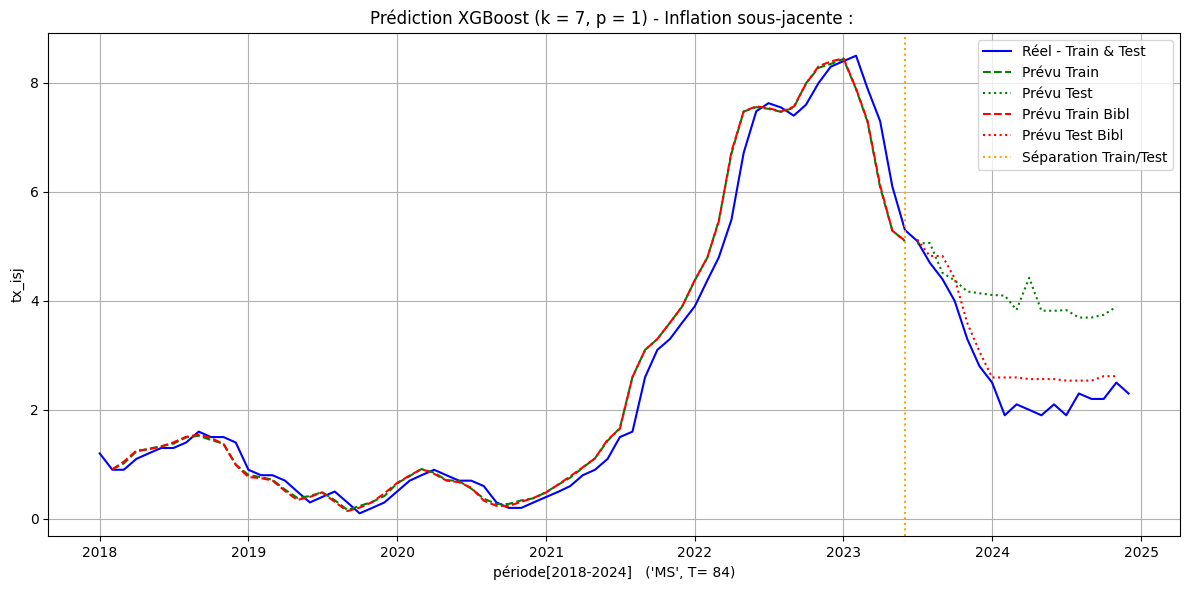

In [47]:
metriques(f"=> Performance de l'implèmentation manuelle de XGBoost(k = {k}, "\
          f"p = {p}, T = {84 if freq=="MS" else 28}) :", 
          y_train, y_train_pred, 
          y_test, y_test_pred)

metriques(f"=> Performance de la bibliothèque XGBRegressor de XGBoost(k = {k}, "\
          f"p = {p}, T = {84 if freq=="MS" else 28}) :", 
          y_train, y_train_pred_bibl,
          y_test, y_test_pred_bibl)

visualisation(f"Prédiction XGBoost (k = {k}, p = {p}) - Inflation sous-jacente : ", 
                y_train, y_test,
                y_train_pred[p:], y_test_pred,
                y_train_pred_bibl[p:], y_test_pred_bibl, 
                p, 0, freq)

##### 4.3 - Analyse :

<pre>
=> Performance de l'implèmentation manuelle de XGBoost(k = 1, p = 1, T = 28) :
   Train : MSE=0.0472 | MAE=0.1854 | R²=0.9940
   Test  : MSE=4.0554 | MAE=1.8541 | R²=-3.2233
=> Performance de la bibliothèque XGBRegressor de XGBoost(k = 1, p = 1, T = 28) :
   Train : MSE=0.1299 | MAE=0.2891 | R²=0.9835
   Test  : MSE=3.0544 | MAE=1.6065 | R²=-2.1809

=> Performance de l'implèmentation manuelle de XGBoost(k = 4, p = 1, T = 28) :
   Train : MSE=0.0249 | MAE=0.1226 | R²=0.9968
   Test  : MSE=2.4273 | MAE=1.4517 | R²=-1.5277
=> Performance de la bibliothèque XGBRegressor de XGBoost(k = 4, p = 1, T = 28) :
   Train : MSE=0.0966 | MAE=0.2258 | R²=0.9877
   Test  : MSE=2.3902 | MAE=1.4399 | R²=-1.4892

=> Performance de l'implèmentation manuelle de XGBoost(k = 7, p = 1, T = 28) :
   Train : MSE=0.0245 | MAE=0.1225 | R²=0.9969
   Test  : MSE=1.1868 | MAE=0.7516 | R²=-0.2360
=> Performance de la bibliothèque XGBRegressor de XGBoost(k = 7, p = 1, T = 28) :
   Train : MSE=0.0946 | MAE=0.2186 | R²=0.9879
   Test  : MSE=2.5561 | MAE=1.4989 | R²=-1.6619

=> Performance de l'implèmentation manuelle de XGBoost(k = 1, p = 1, T = 84) :
   Train : MSE=0.4516 | MAE=0.5511 | R²=0.9419
   Test  : MSE=0.3089 | MAE=0.4487 | R²=0.5942
=> Performance de la bibliothèque XGBRegressor de XGBoost(k = 1, p = 1, T = 84) :
   Train : MSE=0.5801 | MAE=0.6142 | R²=0.9254
   Test  : MSE=0.0932 | MAE=0.2410 | R²=0.8776

=> Performance de l'implèmentation manuelle de XGBoost(k = 4, p = 1, T = 84) :
   Train : MSE=0.0061 | MAE=0.0594 | R²=0.9992
   Test  : MSE=0.9197 | MAE=0.9055 | R²=-0.2081
=> Performance de la bibliothèque XGBRegressor de XGBoost(k = 4, p = 1, T = 84) :
   Train : MSE=0.0078 | MAE=0.0684 | R²=0.9990
   Test  : MSE=0.2892 | MAE=0.4819 | R²=0.6201

=> Performance de l'implèmentation manuelle de XGBoost(k = 7, p = 1, T = 84) :
   Train : MSE=0.0029 | MAE=0.0426 | R²=0.9996
   Test  : MSE=2.4861 | MAE=1.4726 | R²=-2.2656
=> Performance de la bibliothèque XGBRegressor de XGBoost(k = 7, p = 1, T = 84) :
   Train : MSE=0.0061 | MAE=0.0600 | R²=0.9992
   Test  : MSE=0.2999 | MAE=0.4919 | R²=0.6060
</pre>

Sur un échantillon réduit (T = 28, Freq = QS) le modéle XGBoost n'a pas pu généralisé, il a capturé les détailles en entrainement, mais les MSE augmentent et les R² sont négatives en toutes les situation (univariée k=1, multivariée simple k=4, et multivaariée complexe k = 7), montrant sa faiblesse de modèliser les échantillons de petites tailles.<br/>

Sur échantillon étendu (T 84 Freq = MS):<br/>
   - Sur des données univariées (en se basant uniquement sur l’historique de la variable cible avec un ordre p=1), XGBoost a donné des résultats satisfaisants : le MSE diminue et le R² ne baisse que très légèrement sur les données non vues lors de l’utilisation de la bibliothèque, tandis que l’implémentation manuelle présente une baisse un peu plus marquée. Ces résultats confirment la capacité de généralisation du modèle.
   - Sur les données mulivariées simple et complexe, le modél XGBoost a pu généraliser en utilsant la bibliothéque XGBRegressor qui est plus robuste que l'implèmentation manuelle, malgré l'augmenation de MSe, la variance expliquée par le modèle (R²) est diminuer une peu; l'implèmenation manuelle le chute de R² (négative) montre que le modéle est sur-apprenti...

   - Explication : la bibliothèque XGBRegressor, le MSE passe de 0,04 sur le jeu d’entraînement à 0,2 sur le jeu de test, tandis que le R² diminue de 0,99 à 0,72. Cela montre que, malgré une légère perte de performance sur les données non vues, le modèle conserve une bonne capacité de généralisation.

#### 🔹5. Comparaison des performances

In [48]:
import pandas as pd

# Données simplifiées pour démonstration
data = {
    "Modèle": [
        "ARIMA(4,1,2) T28","ARIMA(4,1,2) T28","ARIMA(10,1,8) T84","ARIMA(10,1,8) T84",
        "VAR(1) T28","VAR(1) T28","VAR(1) T84","VAR(1) T84",
        "RNA(k=1,p=1,h=4) T28","RNA(k=1,p=1,h=4) T28",
        "RNA(k=4,p=1,h=4) T28","RNA(k=4,p=1,h=4) T28",
        "RNA(k=7,p=1,h=4) T28","RNA(k=7,p=1,h=4) T28",
        "RNA(k=1,p=1,h=4) T84","RNA(k=1,p=1,h=4) T84",
        "RNA(k=4,p=1,h=4) T84","RNA(k=4,p=1,h=4) T84",
        "RNA(k=7,p=1,h=4) T84","RNA(k=7,p=1,h=4) T84",
        "XGBoost(k=1,p=1) T28","XGBoost(k=1,p=1) T28",
        "XGBoost(k=4,p=1) T28","XGBoost(k=4,p=1) T28",
        "XGBoost(k=7,p=1) T28","XGBoost(k=7,p=1) T28",
        "XGBoost(k=1,p=1) T84","XGBoost(k=1,p=1) T84",
        "XGBoost(k=4,p=1) T84","XGBoost(k=4,p=1) T84",
        "XGBoost(k=7,p=1) T84","XGBoost(k=7,p=1) T84"
    ],
    "Implémentation": [
        "Manuelle","Bibliothèque","Manuelle","Bibliothèque",
        "Manuelle","Bibliothèque","Manuelle","Bibliothèque",
        "Manuelle","Bibliothèque","Manuelle","Bibliothèque",
        "Manuelle","Bibliothèque","Manuelle","Bibliothèque",
        "Manuelle","Bibliothèque","Manuelle","Bibliothèque",
        "Manuelle","Bibliothèque","Manuelle","Bibliothèque",
        "Manuelle","Bibliothèque","Manuelle","Bibliothèque",
        "Manuelle","Bibliothèque","Manuelle","Bibliothèque"
    ],
    "Train": [
        "MSE=3.5926 | R²=0.6050","MSE=0.2520 | R²=0.9669",
        "MSE=1.0036 | R²=0.8854","MSE=0.0554 | R²=0.9928",
        "MSE=5.0867 | R²=0.1347","MSE=0.1358 | R²=0.8496",
        "MSE=0.8366 | R²=0.8915","MSE=0.0575 | R²=0.5608",
        "MSE=0.4179 | R²=0.9468","MSE=0.2956 | R²=0.9624",
        "MSE=0.1169 | R²=0.9851","MSE=0.0728 | R²=0.9907",
        "MSE=0.1415 | R²=0.9820","MSE=0.0128 | R²=0.9984",
        "MSE=0.1324 | R²=0.9830","MSE=0.1300 | R²=0.9833",
        "MSE=0.0678 | R²=0.9913","MSE=0.0452 | R²=0.9942",
        "MSE=0.0635 | R²=0.9918","MSE=0.0323 | R²=0.9958",
        "MSE=0.0472 | R²=0.9940","MSE=0.1299 | R²=0.9835",
        "MSE=0.0249 | R²=0.9968","MSE=0.0966 | R²=0.9877",
        "MSE=0.0245 | R²=0.9969","MSE=0.0946 | R²=0.9879",
        "MSE=0.4516 | R²=0.9419","MSE=0.5801 | R²=0.9254",
        "MSE=0.0061 | R²=0.9992","MSE=0.0078 | R²=0.9990",
        "MSE=0.0029 | R²=0.9996","MSE=0.0061 | R²=0.9992"
    ],
    "Test": [
        "MSE=16.9274 | R²=-16.6282","MSE=1.5659 | R²=-0.6308",
        "MSE=1.1968 | R²=-0.5720","MSE=2.0529 | R²=-1.6966",
        "MSE=9.8068 | R²=-1.0821","MSE=1.1679 | R²=-1.6054",
        "MSE=0.2753 | R²=0.7336","MSE=0.0709 | R²=0.2362",
        "MSE=2.4221 | R²=-1.5223","MSE=4.6155 | R²=-3.8066",
        "MSE=1.0545 | R²=-0.0981","MSE=2.3715 | R²=-1.4697",
        "MSE=7.2124 | R²=-6.5110","MSE=9.2059 | R²=-8.5870",
        "MSE=0.1332 | R²=0.8251","MSE=0.3612 | R²=0.5256",
        "MSE=0.5655 | R²=0.2572","MSE=0.2219 | R²=0.7086",
        "MSE=0.5109 | R²=0.3289","MSE=0.3418 | R²=0.5510",
        "MSE=4.0554 | R²=-3.2233","MSE=3.0544 | R²=-2.1809",
        "MSE=2.4273 | R²=-1.5277","MSE=2.3902 | R²=-1.4892",
        "MSE=1.1868 | R²=-0.2360","MSE=2.5561 | R²=-1.6619",
        "MSE=0.3089 | R²=0.5942","MSE=0.0932 | R²=0.8776",
        "MSE=0.9197 | R²=-0.2081","MSE=0.2892 | R²=0.6201",
        "MSE=2.4861 | R²=-2.2656","MSE=0.2999 | R²=0.6060"
    ]
}

df = pd.DataFrame(data, index=range(1, len(data["Modèle"])+1))

# Ajouter colonne validité selon R² test
def get_validity(r2_str):
    r2 = float(r2_str.split("| R²=")[-1])
    return "✅" if r2 > 0 else "❌"

df["Validité"] = df["Test"].apply(get_validity)

def highlight_icons(val):
    return 'color: green;' if val == "✅" else 'color: red;'

df.style.applymap(highlight_icons, subset=["Validité"]).set_properties(**{'text-align':'center'})

,Modèle,Implémentation,Train,Test,Validité
1,"ARIMA(4,1,2) T28",Manuelle,MSE=3.5926 | R²=0.6050,MSE=16.9274 | R²=-16.6282,❌
2,"ARIMA(4,1,2) T28",Bibliothèque,MSE=0.2520 | R²=0.9669,MSE=1.5659 | R²=-0.6308,❌
3,"ARIMA(10,1,8) T84",Manuelle,MSE=1.0036 | R²=0.8854,MSE=1.1968 | R²=-0.5720,❌
4,"ARIMA(10,1,8) T84",Bibliothèque,MSE=0.0554 | R²=0.9928,MSE=2.0529 | R²=-1.6966,❌
5,VAR(1) T28,Manuelle,MSE=5.0867 | R²=0.1347,MSE=9.8068 | R²=-1.0821,❌
6,VAR(1) T28,Bibliothèque,MSE=0.1358 | R²=0.8496,MSE=1.1679 | R²=-1.6054,❌
7,VAR(1) T84,Manuelle,MSE=0.8366 | R²=0.8915,MSE=0.2753 | R²=0.7336,✅
8,VAR(1) T84,Bibliothèque,MSE=0.0575 | R²=0.5608,MSE=0.0709 | R²=0.2362,✅
9,"RNA(k=1,p=1,h=4) T28",Manuelle,MSE=0.4179 | R²=0.9468,MSE=2.4221 | R²=-1.5223,❌
10,"RNA(k=1,p=1,h=4) T28",Bibliothèque,MSE=0.2956 | R²=0.9624,MSE=4.6155 | R²=-3.8066,❌


In [49]:
for i in range(1, len(df) + 1) : 
    df.loc[i, "Overfitting"] = "-" 
    if i  in model_overfitting : df.loc[i, "Overfitting"] = "oui"
    if i  in model_non_overfitting : df.loc[i, "Overfitting"] = "non"
# Filtrer uniquement "oui" ou "non"
df_filtered = df[df["Overfitting"].isin(["oui"])]
# Appliquer le style
print("La confimation de surapprentissage des mdèles validés :")
styled = df_filtered.style.applymap(highlight_icons, subset=["Validité"]).set_properties(**{'text-align':'center'})
styled

La confimation de surapprentissage des mdèles validés :


,Modèle,Implémentation,Train,Test,Validité,Overfitting
8,VAR(1) T84,Bibliothèque,MSE=0.0575 | R²=0.5608,MSE=0.0709 | R²=0.2362,✅,oui
16,"RNA(k=1,p=1,h=4) T84",Bibliothèque,MSE=0.1300 | R²=0.9833,MSE=0.3612 | R²=0.5256,✅,oui
17,"RNA(k=4,p=1,h=4) T84",Manuelle,MSE=0.0678 | R²=0.9913,MSE=0.5655 | R²=0.2572,✅,oui
19,"RNA(k=7,p=1,h=4) T84",Manuelle,MSE=0.0635 | R²=0.9918,MSE=0.5109 | R²=0.3289,✅,oui
20,"RNA(k=7,p=1,h=4) T84",Bibliothèque,MSE=0.0323 | R²=0.9958,MSE=0.3418 | R²=0.5510,✅,oui
27,"XGBoost(k=1,p=1) T84",Manuelle,MSE=0.4516 | R²=0.9419,MSE=0.3089 | R²=0.5942,✅,oui


In [50]:
df_filtered = df[df["Overfitting"].isin(["non"])]
# Appliquer le style
print("La confimation de bonne apprentissage des mdèles validés :")
styled = df_filtered.style.applymap(highlight_icons, subset=["Validité"]).set_properties(**{'text-align':'center'})
styled

La confimation de bonne apprentissage des mdèles validés :


,Modèle,Implémentation,Train,Test,Validité,Overfitting
7,VAR(1) T84,Manuelle,MSE=0.8366 | R²=0.8915,MSE=0.2753 | R²=0.7336,✅,non
15,"RNA(k=1,p=1,h=4) T84",Manuelle,MSE=0.1324 | R²=0.9830,MSE=0.1332 | R²=0.8251,✅,non
18,"RNA(k=4,p=1,h=4) T84",Bibliothèque,MSE=0.0452 | R²=0.9942,MSE=0.2219 | R²=0.7086,✅,non
28,"XGBoost(k=1,p=1) T84",Bibliothèque,MSE=0.5801 | R²=0.9254,MSE=0.0932 | R²=0.8776,✅,non
30,"XGBoost(k=4,p=1) T84",Bibliothèque,MSE=0.0078 | R²=0.9990,MSE=0.2892 | R²=0.6201,✅,non
32,"XGBoost(k=7,p=1) T84",Bibliothèque,MSE=0.0061 | R²=0.9992,MSE=0.2999 | R²=0.6060,✅,non


#### 🔹6. Conclusion

En s'apuyant uniquement sur les données passées :
* ARIMA : n 'a pas pu généraliser, mais il a donné des signes prometeuse en augmentant la tailles de l'échantillon.
* Les modèles de ML, RNA (15) et (16) et XCGoost (27) et (28) ont donné des résultat satififaisant indiquant leurs capacités de prévoir sur des données univariéesè(T=84), mais ont montré aussi leur faiblesse sur des petits échantillons(T=28).<br/>

Sur des échantillons simple (conteant que les variables causales) réduit et étendu :
* Les modèles VAR (5) et (6), RNA (11) et (12), XGBoost (23) et (25) n'ont pas pu généraliser en sur-apprenant, ou parfois sous-apprenant sur un échnatillon réduit(T=28).
* Le modéle VAR sur un échatillon étendu (T=84) a pu généraliser en implèmentation manuelle (7) et moins performant en utilisant la bibliothèque VAR(8), il nous a permet de déterminer les variables qui ont des relations liniarire directe avec la variable cible.
* Les modèles ML sur un échantillon étendu (T=84), le RNA (17) et (18) ont pu généraliser malgré que le MSE ont augmentés, l'usage de bibliothèque Keras est plus performant, presque même résultat avec le modèle XGBoost (30), l'implentation manuelle a sur-apprenti.

Sur des données multivariées complexes :
* Le modèle VAR n'est validé qu'aprés exclure les variables qui n'ont pas de relations linéaire avec la variables cibles, donc les modèles de machines ML qui prenent en charger les relations linéaires et non-linéaires, Les RNA (19) et (20) ont pu généraliser avec une performance modérée, la bibliothèque XGBRogresser (32) a donné un résultat meilleur, mais l'implèmentation manuelle a sur-apprenti.